# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "../data"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [7]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [9]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 47.3 s, sys: 181 ms, total: 47.5 s
Wall time: 7.13 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [10]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [11]:
y_pred

array([0.65471396, 0.54619925, 0.36613405, ..., 0.57893826, 0.43158454,
       0.60862043])

In [12]:
y_valid

array([1, 1, 0, ..., 1, 0, 1], dtype=int8)

In [13]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [14]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [15]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [16]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_16-49-39.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [17]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
cv

ShuffleSplit(n_splits=5, random_state=10801, test_size=0.3, train_size=None)

In [18]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 9.26 s, sys: 692 ms, total: 9.95 s
Wall time: 53.4 s


In [19]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [20]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [21]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [22]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [203]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

In [49]:
player.keys()

dict_keys(['player_slot', 'hero_id', 'hero_name', 'account_id_hash', 'ability_upgrades', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'stuns', 'max_hero_hit', 'times', 'gold_t', 'lh_t', 'dn_t', 'xp_t', 'obs_log', 'sen_log', 'obs_left_log', 'sen_left_log', 'purchase_log', 'kills_log', 'buyback_log', 'runes_log', 'obs', 'sen', 'actions', 'pings', 'purchase', 'gold_reasons', 'xp_reasons', 'killed', 'item_uses', 'ability_uses', 'hero_hits', 'damage', 'damage_taken', 'damage_inflictor', 'runes', 'killed_by', 'kill_streaks', 'multi_kills', 'life_state', 'healing', 'damage_inflictor_received', 'randomed', 'pred_vict', 'gold', 'lh', 'xp', 'x', 'y', 'hero_inventory', 'hero_stash', 'health', 'max_health', 'max_mana', 'level', 'kills', 'deaths', 'assists', 'denies', 'nearby_creep_death_count'])

In [58]:
player = match["players"][3]
player['ability_upgrades']

[{'ability': 5110, 'time': 326, 'level': 1},
 {'ability': 5112, 'time': 406, 'level': 2},
 {'ability': 5111, 'time': 462, 'level': 3},
 {'ability': 5111, 'time': 526, 'level': 4},
 {'ability': 5111, 'time': 602, 'level': 5},
 {'ability': 5113, 'time': 650, 'level': 6},
 {'ability': 5111, 'time': 726, 'level': 7},
 {'ability': 5110, 'time': 796, 'level': 8},
 {'ability': 5110, 'time': 859, 'level': 9},
 {'ability': 5987, 'time': 964, 'level': 10},
 {'ability': 5110, 'time': 1040, 'level': 11},
 {'ability': 5113, 'time': 1191, 'level': 12},
 {'ability': 5112, 'time': 1272, 'level': 13},
 {'ability': 5112, 'time': 1352, 'level': 14},
 {'ability': 6093, 'time': 1547, 'level': 15},
 {'ability': 5112, 'time': 1616, 'level': 16},
 {'ability': 5113, 'time': 1687, 'level': 17},
 {'ability': 5951, 'time': 2009, 'level': 18}]

In [59]:
df_train_features.loc[match["match_id_hash"],'r4_level']

25

Ability upgrade != player level

In [69]:
# max_hero_hit
# This is weird - I don't think this could be necessary
print(player['hero_name'])
print(player['max_hero_hit'])

# times - just list of times
print(player['times'])

# gold_t (and other variables with _t in the end seem to correspond to variables at specific times)
print(player['gold_t'])

npc_dota_hero_zuus
{'type': 'max_hero_hit', 'time': 1971.046, 'max': True, 'inflictor': 'zuus_thundergods_wrath', 'unit': 'npc_dota_hero_zuus', 'key': 'npc_dota_hero_faceless_void', 'value': 344, 'slot': 3, 'player_slot': 3}
[0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140, 1200, 1260, 1320, 1380, 1440, 1500, 1560, 1620, 1680, 1740, 1800, 1860, 1920, 1980, 2040]
[1, 308, 799, 1201, 1588, 2164, 2740, 3169, 3639, 3991, 4657, 5267, 5587, 5935, 6362, 6656, 7473, 7764, 8175, 8396, 9212, 10204, 10816, 11458, 12083, 12476, 12668, 13270, 13789, 15381, 16123, 16532, 18204, 19756, 20263]


In [72]:
for key in player.keys():
    if key.endswith("_log"):
        print(key)
        print(player[key])

obs_log
[{'time': 42.156, 'tick': 11320, 'type': 'obs_log', 'key': '[122, 132]', 'slot': 3, 'x': 122, 'y': 132, 'z': 130, 'entityleft': False, 'ehandle': 15107128, 'player_slot': 3}]
sen_log
[]
obs_left_log
[{'time': 408.267, 'tick': 22306, 'type': 'obs_left_log', 'key': '[122, 132]', 'slot': 3, 'x': 122, 'y': 132, 'z': 130, 'entityleft': True, 'ehandle': 15107128, 'player_slot': 3}]
sen_left_log
[]
purchase_log
[{'time': -89.945, 'key': 'clarity'}, {'time': -89.945, 'key': 'tpscroll'}, {'time': -74.215, 'key': 'circlet'}, {'time': -74.149, 'key': 'mantle'}, {'time': -74.149, 'key': 'null_talisman'}, {'time': 100.409, 'key': 'bottle'}, {'time': 102.108, 'key': 'clarity'}, {'time': 192.42, 'key': 'gloves'}, {'time': 194.186, 'key': 'clarity'}, {'time': 440.159, 'key': 'hand_of_midas'}, {'time': 454.056, 'key': 'boots'}, {'time': 600.487, 'key': 'tome_of_knowledge'}, {'time': 651.641, 'key': 'tpscroll'}, {'time': 651.841, 'key': 'tpscroll'}, {'time': 685.966, 'key': 'arcane_boots'}, {'ti

In [73]:
for key in player.keys():
    if key.endswith("_reasons"):
        print(key)
        print(player[key])

gold_reasons
{'0': 1842, '1': -1874, '2': -205, '6': 1082, '11': 1675, '12': 3254, '13': 10676, '14': 150, '15': 175}
xp_reasons
{'0': 29, '1': 10383, '2': 17084}


In [96]:
# Idk what this is - maybe number of actions? could be useful
print(player['actions']) #-?
print(sum(player['actions'].values()))

{'1': 3399, '2': 45, '3': 4, '4': 124, '5': 18, '6': 75, '7': 2, '8': 34, '10': 95, '11': 10, '15': 52, '16': 34, '19': 13, '23': 1, '24': 3, '27': 8, '33': 95}
4012


In [87]:
# finally something more productive
print(player['item_uses'])
print(sum(player['item_uses'].values()))
print(player['ability_uses'])
print(sum(player['ability_uses'].values()))

{'ward_sentry': 1, 'tango': 6, 'tpscroll': 9, 'ward_observer': 8, 'clarity': 4, 'smoke_of_deceit': 5, 'tome_of_knowledge': 3, 'ward_dispenser': 7, 'magic_wand': 5, 'dust': 2, 'urn_of_shadows': 4, 'spirit_vessel': 4}
58
{'pudge_rot': 121, 'pudge_meat_hook': 24, 'pudge_dismember': 14}
159


In [94]:
# Number of hits inflicted
print(player['hero_hits'])
print(sum(player['hero_hits'].values()))
# Inflictde Damage
print(player['damage'])
print(sum(player['damage'].values()))
# Taken Damage
print(player['damage_taken'])
print(sum(player['damage_taken'].values()))
# Damage inflictor?
print(player['damage_inflictor'])
print(sum(player['damage_inflictor'].values()))

{'pudge_rot': 1374, 'null': 29, 'pudge_meat_hook': 12, 'pudge_dismember': 10, 'urn_of_shadows': 7, 'spirit_vessel': 9}
1441
{'npc_dota_hero_dragon_knight': 5266, 'npc_dota_hero_pudge': 14323, 'npc_dota_hero_leshrac': 1395, 'npc_dota_creep_badguys_ranged': 2619, 'npc_dota_creep_badguys_melee': 8951, 'npc_dota_creep_goodguys_melee': 408, 'npc_dota_hero_storm_spirit': 1025, 'npc_dota_hero_treant': 2683, 'npc_dota_creep_goodguys_ranged': 79, 'npc_dota_badguys_siege': 539, 'illusion_npc_dota_hero_storm_spirit': 530, 'npc_dota_badguys_tower2_mid': 231, 'npc_dota_neutral_polar_furbolg_champion': 1419, 'npc_dota_neutral_polar_furbolg_ursa_warrior': 1943, 'npc_dota_neutral_centaur_outrunner': 1070, 'npc_dota_neutral_centaur_khan': 2293, 'npc_dota_neutral_gnoll_assassin': 1107, 'npc_dota_neutral_harpy_scout': 814, 'npc_dota_neutral_harpy_storm': 558, 'npc_dota_neutral_mud_golem': 1565, 'npc_dota_neutral_mud_golem_split': 1077, 'npc_dota_badguys_range_rax_bot': 173, 'npc_dota_hero_faceless_void':

In [95]:
player = match["players"][9]

# Number of hits inflicted
print(player['hero_hits'])
print(sum(player['hero_hits'].values()))
# Inflicted Damage
print(player['damage'])
print(sum(player['damage'].values()))
# Taken Damage
print(player['damage_taken'])
print(sum(player['damage_taken'].values()))
# Damage inflictor to which champions and how much
print(player['damage_inflictor'])
print(sum(player['damage_inflictor'].values()))

{'null': 11, 'treant_leech_seed': 22}
33
{'npc_dota_hero_lich': 328, 'npc_dota_creep_badguys_ranged': 88, 'npc_dota_creep_badguys_melee': 509, 'npc_dota_neutral_fel_beast': 178, 'npc_dota_neutral_gnoll_assassin': 353, 'npc_dota_neutral_kobold_taskmaster': 91, 'npc_dota_neutral_kobold': 97, 'npc_dota_neutral_polar_furbolg_champion': 321, 'npc_dota_neutral_polar_furbolg_ursa_warrior': 154, 'npc_dota_creep_goodguys_melee': 2349, 'npc_dota_neutral_harpy_storm': 90, 'npc_dota_hero_antimage': 545, 'npc_dota_hero_zuus': 327, 'npc_dota_creep_goodguys_ranged': 596, 'npc_dota_hero_pudge': 87}
6113
{'npc_dota_goodguys_tower1_top': 263, 'npc_dota_hero_lich': 1781, 'npc_dota_neutral_fel_beast': 48, 'npc_dota_neutral_ghost': 107, 'npc_dota_neutral_polar_furbolg_champion': 150, 'npc_dota_neutral_polar_furbolg_ursa_warrior': 232, 'npc_dota_neutral_gnoll_assassin': 163, 'npc_dota_neutral_kobold_tunneler': 18, 'npc_dota_neutral_kobold_taskmaster': 10, 'npc_dota_neutral_kobold': 25, 'npc_dota_creep_goodg

What is present in our dataset:

team_features = `[
     'kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y',
     'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
     'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed',
    ]`
    
**Important lacking features in my opinion**
* Sum of taken/inflicted damage
* Number of item and ability uses
* maybe number of taken actions?
* number of ability upgrades
* number of item/purchases

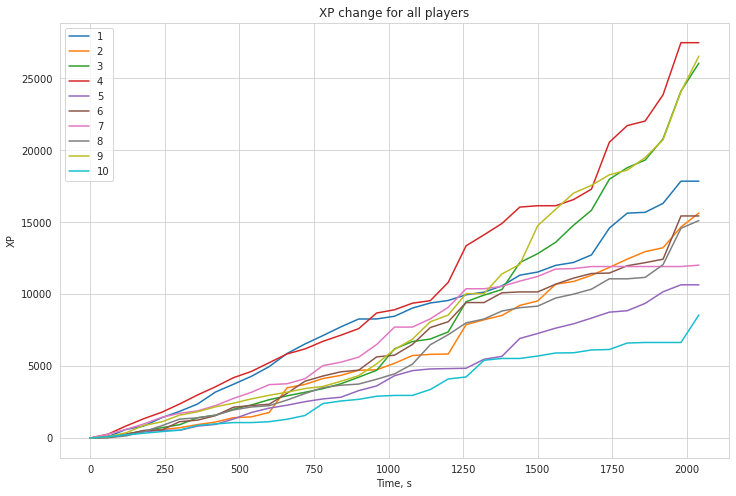

In [24]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [25]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [462]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
#         radiant_tower_kills = 0
#         dire_tower_kills = 0
#         for objective in match["objectives"]:
#             if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
#                 if objective["team"] == 2:
#                     radiant_tower_kills += 1
#                 if objective["team"] == 3:
#                     dire_tower_kills += 1
#         I already have these features because I sum up the teams statistics later
#         df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
#         df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
#         df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

        for i, player in enumerate(match['players']):
            if i <= 4:
                player_name = "r" + str(i+1)
            else:
                player_name = "d" + str(i-4)
            # Inflicted Damage
            damage = sum(player['damage'].values())
            # Taken Damage
            damage_taken = sum(player['damage_taken'].values())
            # Item uses
            item_uses = sum(player['item_uses'].values())
            # Ability uses
            ability_uses = sum(player['ability_uses'].values())
            # Number of actions
            actions = sum(player['actions'].values())
            # Number of ability upgrades
            num_ab_upg = len(player['ability_upgrades'])
            # Number of items/purchases
            num_purch = len(player['purchase_log'])
#             # Number of runes
#             num_runs = len(player['runes_log'])
            
            df_features.loc[match_id_hash, player_name + "_damage"] = damage
            df_features.loc[match_id_hash, player_name + "_damage_taken"] = damage_taken
            df_features.loc[match_id_hash, player_name + "_item_uses"] = item_uses
            df_features.loc[match_id_hash, player_name + "_ability_uses"] = ability_uses
            df_features.loc[match_id_hash, player_name + "_actions"] = actions
            df_features.loc[match_id_hash, player_name + "_num_ab_upg"] = num_ab_upg
            df_features.loc[match_id_hash, player_name + "_num_purch"] = num_purch
#             df_features.loc[match_id_hash, player_name + "_num_runs"] = num_runs
            


In [190]:
# Скопируем таблицу с признаками
df_train_features_extended_players = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended_players, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [191]:
df_train_features_extended_players.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d9_num_purch,d9_num_runs,d10_damage,d10_damage_taken,d10_item_uses,d10_ability_uses,d10_actions,d10_num_ab_upg,d10_num_purch,d10_num_runs
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,23.0,6.0,2308.0,2154.0,9.0,7.0,760.0,4.0,11.0,0.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,5.0,0.0,0.0,0.0,1.0,0.0,19.0,0.0,4.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,10.0,0.0,4496.0,948.0,2.0,2.0,510.0,0.0,9.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,10.0,1.0,4682.0,1608.0,14.0,32.0,2531.0,5.0,21.0,3.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,19.0,4.0,2156.0,1593.0,8.0,19.0,1323.0,2.0,14.0,0.0


In [192]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended_players.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 123 ms, sys: 313 ms, total: 436 ms
Wall time: 1min 38s


In [193]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7927822004297722
ROC-AUC на кросс-валидации для новых признаков: 0.7726092798509615


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

# EDA on source data

In [26]:
df_train_features.describe()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
count,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,...,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000
mean,1146.519496,19.583538,4.771563,6.535239,7.358982,51.081614,3.151713,3.273361,4.661998,6.255600,...,11.773022,1.021957,0.338381,4.697363,0.088965,0.416247,0.299640,0.024449,1.255568,0.780933
std,766.936655,6.306635,3.260899,6.486933,13.295763,34.573173,3.727116,3.281208,5.207887,8.144267,...,20.400131,3.427767,0.946140,4.662255,0.284697,0.267604,0.730835,0.172030,2.582681,2.436478
min,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-3.294393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,521.000000,22.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.235294,0.000000,0.000000,0.000000,0.000000
50%,1044.000000,22.000000,7.000000,4.000000,3.000000,44.000000,2.000000,2.000000,3.000000,3.000000,...,1.532971,0.000000,0.000000,3.000000,0.000000,0.444444,0.000000,0.000000,0.000000,0.000000
75%,1659.000000,22.000000,7.000000,10.000000,9.000000,81.000000,5.000000,5.000000,7.000000,9.000000,...,16.129388,0.000000,0.000000,7.000000,0.000000,0.600000,0.000000,0.000000,1.000000,0.000000
max,4933.000000,23.000000,7.000000,43.000000,291.000000,120.000000,32.000000,27.000000,40.000000,83.000000,...,222.612630,107.000000,29.000000,57.000000,1.000000,2.000000,9.000000,5.000000,26.000000,47.000000


Object types:

In [27]:
df_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31698 entries, b9c57c450ce74a2af79c9ce96fac144d to e2ca68ac1a6847f4a37f6c9c8ee8695b
Columns: 245 entries, game_time to d5_sen_placed
dtypes: float64(30), int64(215)
memory usage: 59.5+ MB


NA values:

In [28]:
df_train_features.isnull().sum().sum()

0

Game time distribution:

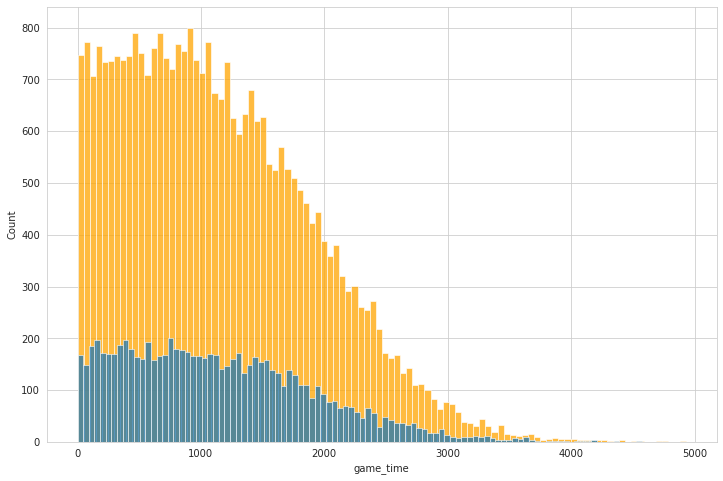

In [29]:
sns.histplot(df_train_features['game_time'], bins=100, color='orange')
sns.histplot(df_test_features['game_time'], bins=100);

Game mode:

In [30]:
df_train_features['game_mode'].value_counts()

22    25324
4      2877
23     2079
3       948
2       315
5       148
12        5
16        2
Name: game_mode, dtype: int64

In [31]:
df_test_features['game_mode'].value_counts()

22    6438
4      687
23     467
3      252
2       93
5       40
Name: game_mode, dtype: int64

In [32]:
df = df_train_features.merge(df_train_targets, on='match_id_hash')

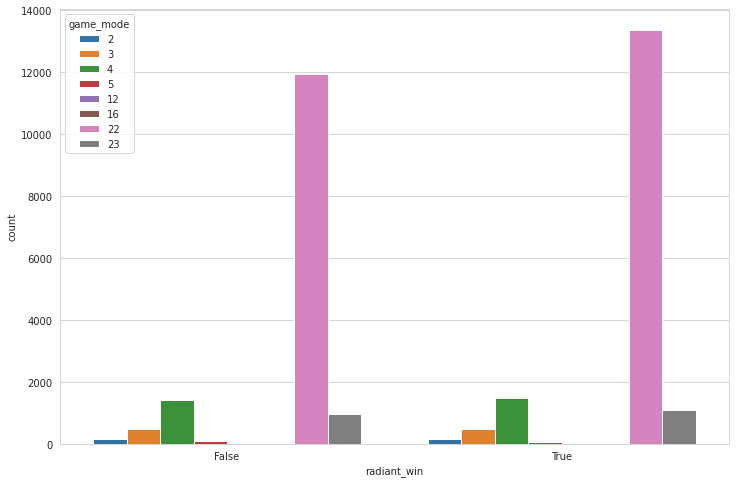

In [33]:
sns.countplot(df['radiant_win'], hue=df['game_mode']);

-> approximately same shape, variable does not really matter

Lobby type:

In [34]:
df_train_features['lobby_type'].value_counts()

7    21607
0    10091
Name: lobby_type, dtype: int64

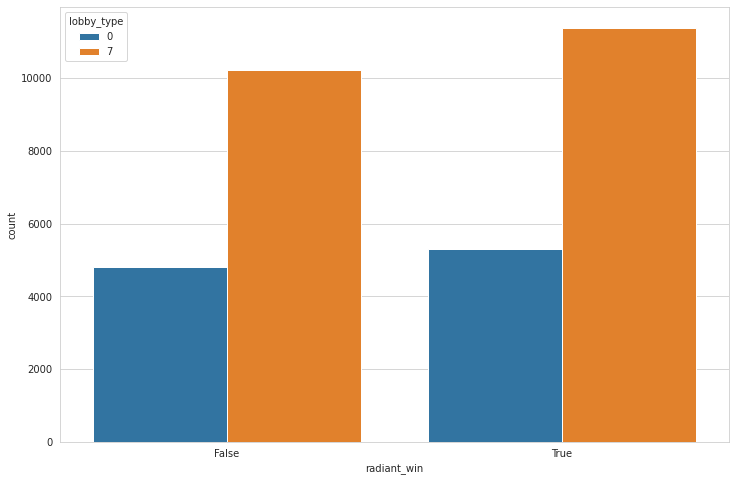

In [35]:
sns.countplot(df['radiant_win'], hue=df['lobby_type']);

-> approximately same shape irrespective of the win/loss, variable does not really matter

Chat length:

In [36]:
df_train_features['chat_len'].value_counts()

0      8634
1      3812
2      2797
3      2154
4      1734
       ... 
158       1
116       1
224       1
104       1
115       1
Name: chat_len, Length: 152, dtype: int64

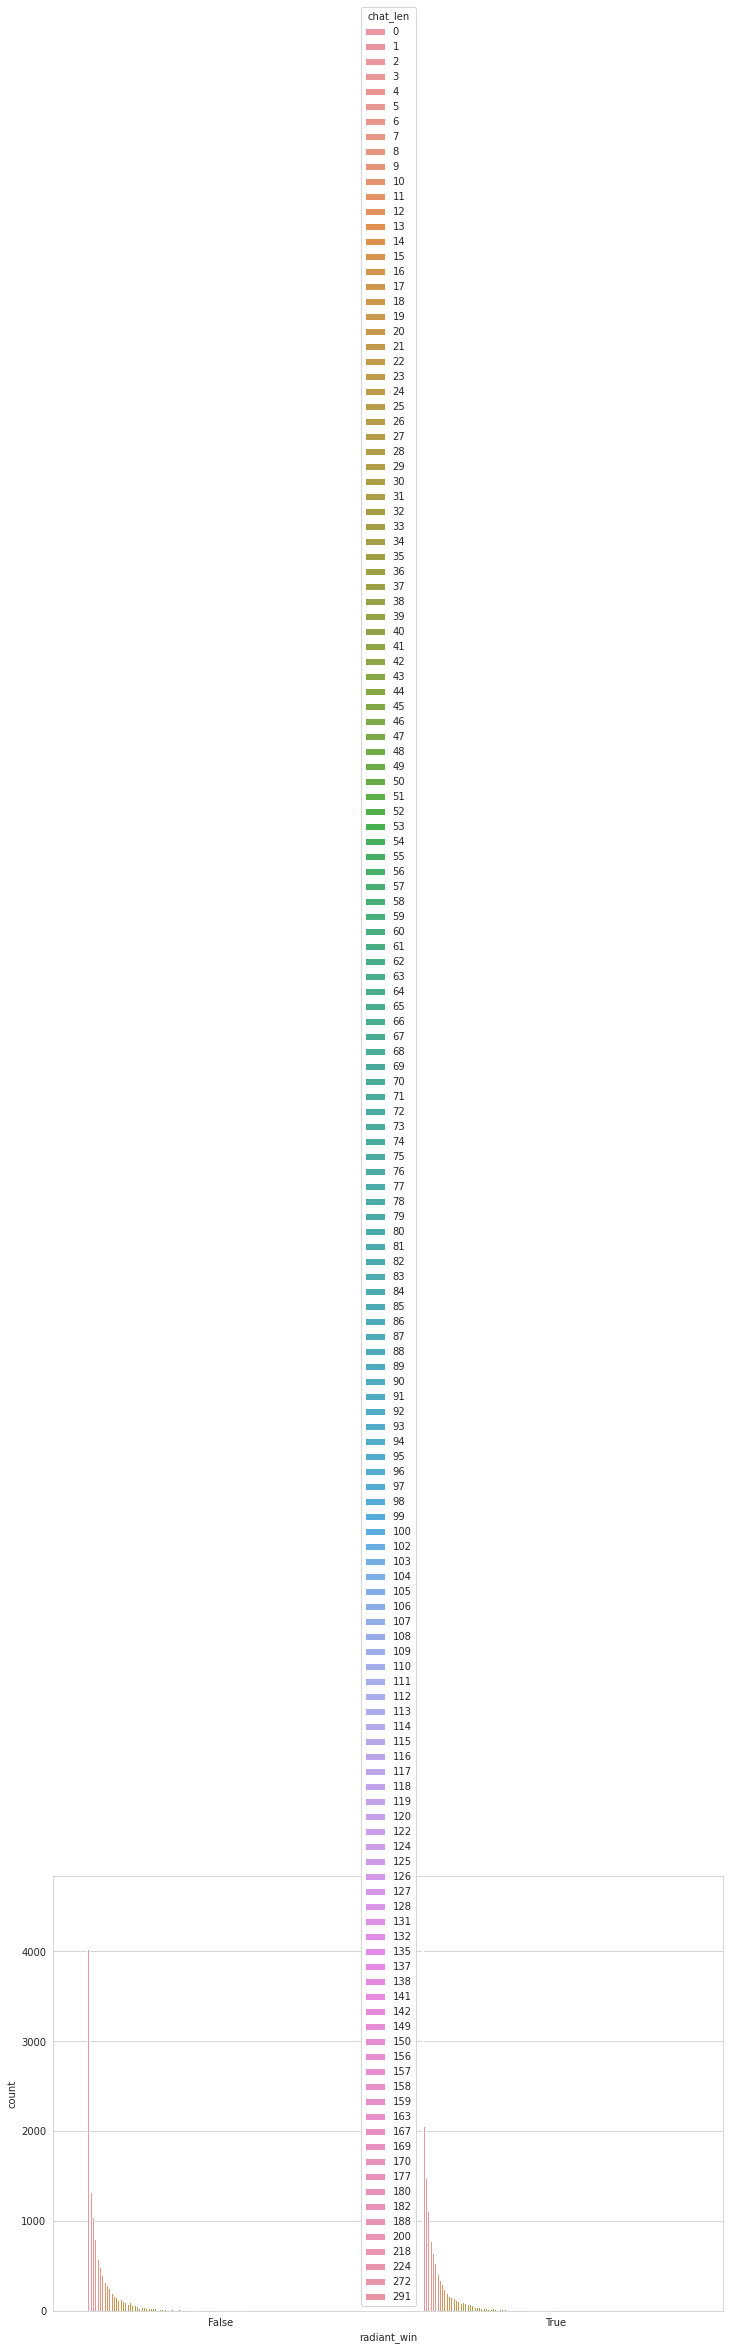

In [37]:
sns.countplot(df['radiant_win'], hue=df['chat_len']);

-> approximately same shape irrespective of the win/loss, variable does not really matter

In [38]:
df_train_features['chat_len'].value_counts()

0      8634
1      3812
2      2797
3      2154
4      1734
       ... 
158       1
116       1
224       1
104       1
115       1
Name: chat_len, Length: 152, dtype: int64

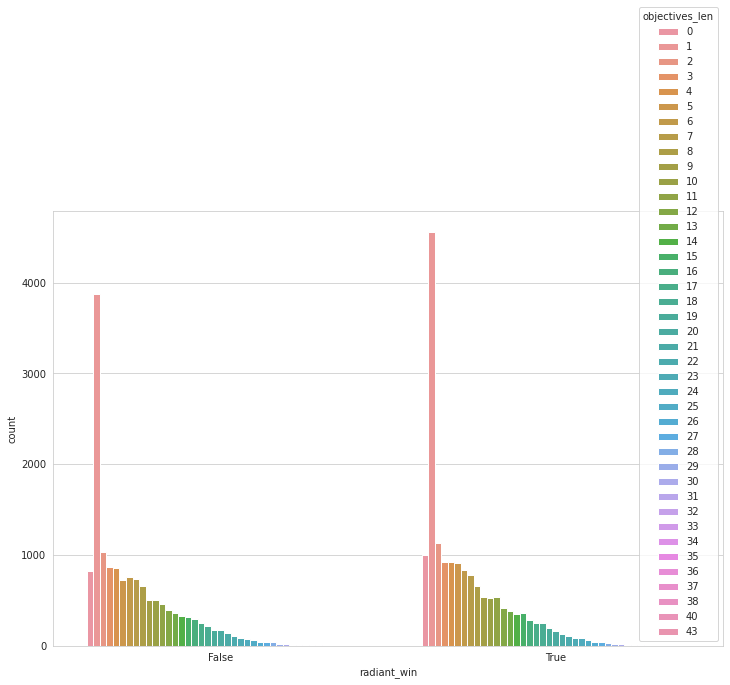

In [39]:
sns.countplot(df['radiant_win'], hue=df['objectives_len']);

-> approximately same shape irrespective of the win/loss, variable does not really matter

Taking a look at the statistics/features available for each player:

In [40]:
filter_col = [col for col in df_train_features if col.startswith('r1')]
filter_col

['r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed']

Let's be realistic, it does not matter which exact player in the team has how much gold, but rather - the whole statistics for the team. Therefore, we will group all the statistics for each player into statistics for one team.

There are three ways to do this. We either sum up everything - gold, kills, etc., and have one total feature, or we still preserve some kind of statistics for each player. E.g., we take mean, max, min, std, or 75th quantile or whatever, or we combine all of them - have total, mean and std. I'm going to try the models with both and see which one works better.

In [398]:
def team_transformation(df, total=True, mean=True, std=True, max_=True, min_=True):
    df_transf = df.copy()
    
    teams = ['r', 'd']
    team_features = [
     'kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y',
     'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
     'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed',
#      'ability_level', 'max_hero_hit', 'purchase_count',
#      'count_ability_use', 'damage_dealt', 'damage_received'
    ]
    
    for team in teams:
        for feature in team_features:
            if feature != 'health':
                filter_col = [col for col in df_transf if col.endswith(feature) and col.startswith(team)]
            else:
                filter_col = [col for col in df_transf if col.endswith(feature) and col.startswith(team) and not col.endswith("max_health")]
            
            if total:
                df_transf[team + "_total_" + feature] = df_transf[filter_col].sum(axis=1)
            
            if mean:
                df_transf[team + "_mean_" + feature] = df_transf[filter_col].mean(axis=1)
            
            if std:
                df_transf[team + _"std_" + feature] = df_transf[filter_col].std(axis=1)
                
            if max_:
                df_transf[team + "_max_" + feature] = df_transf[filter_col].max(axis=1)

            if min_:
                df_transf[team + "_min_" + feature] = df_transf[filter_col].min(axis=1)
            
            df_transf.drop(columns=filter_col, inplace=True)
            
    return df_transf

In [399]:
df_train_features_team_group = team_transformation(df_train_features, total=True, mean=False, std=False, max_=False, min_=False)

In [43]:
df_train_features_team_group.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
       'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id',
       'r_total_kills', 'r_total_deaths', 'r_total_assists', 'r_total_denies',
       'r_total_gold', 'r_total_lh', 'r_total_xp', 'r_total_health',
       'r_total_max_health', 'r_total_max_mana', 'r_total_level', 'r_total_x',
       'r_total_y', 'r_total_stuns', 'r_total_creeps_stacked',
       'r_total_camps_stacked', 'r_total_rune_pickups',
       'r_total_firstblood_claimed', 'r_total_teamfight_participation',
       'r_total_towers_killed', 'r_total_roshans_killed', 'r_total_obs_placed',
       'r_total_sen_placed', 'd_total_kills', 'd_total_deaths',
       'd_total_assists', 'd_total_denies', 'd_total_gold', 'd_total_lh',
       'd_total_xp', 'd_total_health', 'd_total_max_health',
       'd_total_max_mana', 'd_total_level', 'd_total_x', 'd_total_y',
  

**Hero-ID**

Unique hero ids count:

In [44]:
filter_col = [col for col in df_train_features_team_group if col.endswith("hero_id")]
un_hero_id = pd.unique(df_train_features_team_group[filter_col].values.ravel("K"))

In [45]:
np.sort(un_hero_id)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 119, 120])

In [46]:
len(un_hero_id)

115

In [47]:
filter_col = [col for col in df_test_features if col.endswith("hero_id")]
un_hero_id = pd.unique(df_train_features_team_group[filter_col].values.ravel("K"))

In [48]:
np.sort(un_hero_id)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 119, 120])

In [49]:
len(un_hero_id)

115

Ok, due to reasons we have some kind of jump in numerating order in the end. Now let's try to encode them with win rate of the champions.

Check how many times champion an even be in the teams (just once in a team, once in each team, or many times).

In [50]:
df_hero_ids = df_train_features_team_group[filter_col]
r_hero_ids = df_hero_ids[[col for col in df_hero_ids if col.startswith("r")]]
d_hero_ids = df_hero_ids[[col for col in df_hero_ids if col.startswith("d")]]

Check if it is possible to have the team with just one type of champion:

In [51]:
num_when_all_champ_same = 0
for i in un_hero_id:
    num_when_all_champ_same += (df_hero_ids == i).all(1).sum()
num_when_all_champ_same

0

So not the case.

For each team:

In [52]:
num_when_all_champ_same_per_group = 0
for i in un_hero_id:
    num_when_all_champ_same_per_group += (r_hero_ids == i).all(1).sum()
    num_when_all_champ_same_per_group += (d_hero_ids == i).all(1).sum()

num_when_all_champ_same_per_group

0

So not the case.

Check if it is possible to have the same champion more than once in two teams:

In [53]:
for hero in un_hero_id:
    if (df_hero_ids == hero).sum(axis=1).max() > 1:
        print(hero)

Apparently not. Therefore we can assume that each champion only once in the whole game. 

Now we can proceed to encode the win rate. We take the `df` with our precious target values and shrink it down to hero ids and the wins.

In [54]:
filter_col = [col for col in df if col.endswith("hero_id") or col == "radiant_win"]
df_hero_win_rate = df[filter_col]
df_hero_win_rate["radiant_win"] = df_hero_win_rate["radiant_win"].map({True:1, False:0})

Formula for calculating the win rate:
$win \; rate = \frac{Number \; of \; wins \; with \; this \; hero}{Number \; of \; matches \; played \; with \; this \; hero} $

Due to the fact that we know that each champion is only once in the game, we can just take the value counts of the champion as it is equal to number of matches played with this champion.

Counting of number of matches played for each hero:

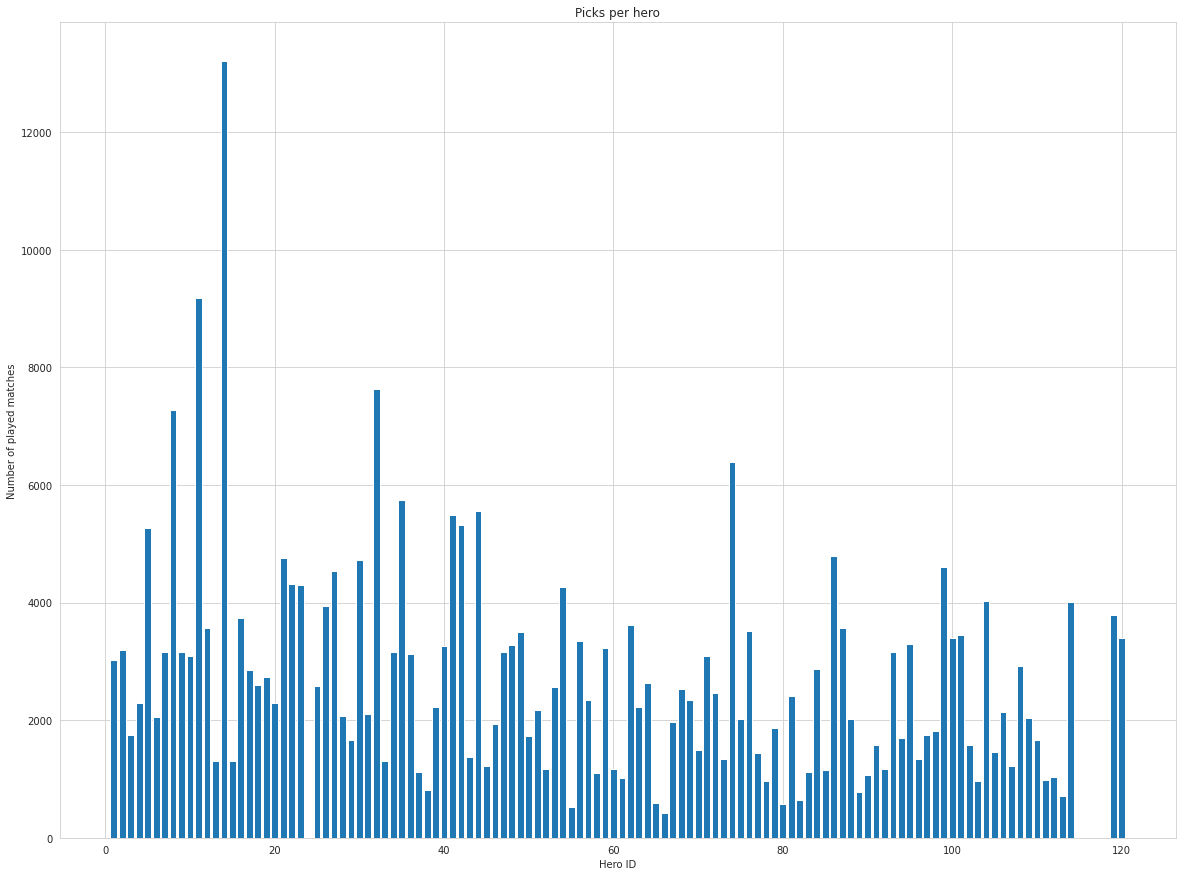

In [55]:
filter_col = [col for col in df_hero_win_rate if col.endswith("hero_id")]

hero_tot_matches = {}

for hero in un_hero_id:
    hero_tot_matches[hero] = (df_hero_win_rate[filter_col] == hero).any(axis=1).sum()
    

# How many times was each champion played? As we can see, some of them are quite popular
plt.figure(figsize=(20, 15))
plt.bar(hero_tot_matches.keys(), hero_tot_matches.values())
plt.ylabel("Number of played matches")
plt.xlabel("Hero ID")
plt.title("Picks per hero");

Now let's calculate wins for each champion:

In [56]:
hero_wins = {}

r_filter_col = filter_col = [col for col in df_hero_win_rate if col.startswith("r") and col.endswith("hero_id")]
d_filter_col = filter_col = [col for col in df_hero_win_rate if col.startswith("d") and col.endswith("hero_id")]


for hero in un_hero_id:
    hero_wins[hero] = len(df_hero_win_rate[(df_hero_win_rate[r_filter_col] == hero).any(axis=1) & (df_hero_win_rate['radiant_win'] == 1)])
    hero_wins[hero] += len(df_hero_win_rate[(df_hero_win_rate[d_filter_col] == hero).any(axis=1) & (df_hero_win_rate['radiant_win'] == 0)])

Calculating win rate:

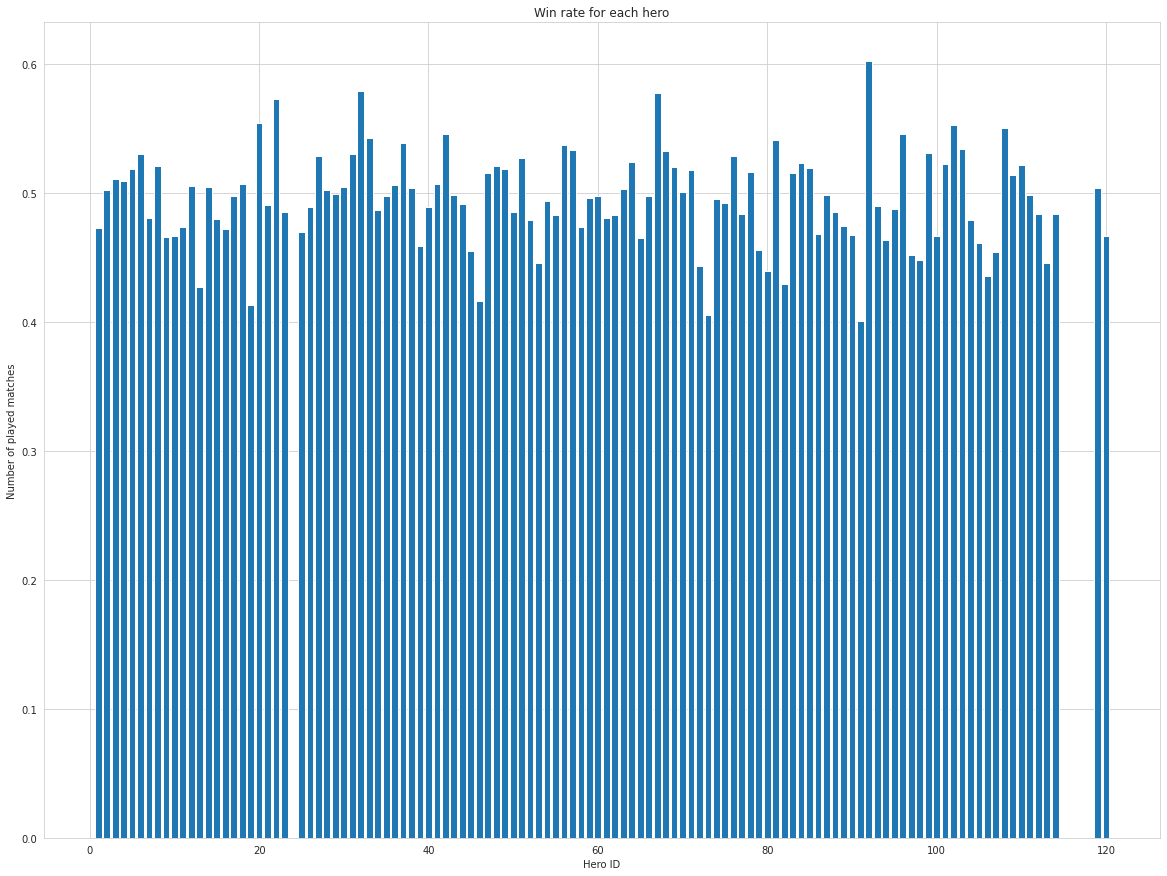

In [57]:
hero_win_rate = {}

for hero in un_hero_id:
    hero_win_rate[hero] = hero_wins[hero] / hero_tot_matches[hero]

# How many times was each champion played? As we can see, some of them are quite popular
plt.figure(figsize=(20, 15))
plt.bar(hero_win_rate.keys(), hero_win_rate.values())
plt.ylabel("Number of played matches")
plt.xlabel("Hero ID")
plt.title("Win rate for each hero");

Now we change the hero ID with its win rate:

In [58]:
filter_col = [col for col in df_hero_win_rate if col.endswith("hero_id")]
replace_dic = {i:hero_win_rate for i in filter_col}

In [59]:
df_train_features_team_group_win_rate = df_train_features_team_group.replace(replace_dic)

In [60]:
df_train_features_team_group_win_rate

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,d_total_stuns,d_total_creeps_stacked,d_total_camps_stacked,d_total_rune_pickups,d_total_firstblood_claimed,d_total_teamfight_participation,d_total_towers_killed,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,0.479358,0.545319,0.528971,0.503371,0.474359,...,3.532506,3,2,14,1,1.500000,0,0,5,2
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0.522029,0.527214,0.491272,0.518550,0.445614,...,0.000000,0,0,1,0,0.000000,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,0.532962,0.466926,0.541269,0.447745,0.503966,...,0.000000,0,0,0,0,0.000000,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,0.503966,0.517799,0.491272,0.497302,0.550531,...,48.488246,0,0,12,0,2.000000,0,0,7,1
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,0.505334,0.518550,0.400759,0.483508,0.485303,...,46.016229,6,2,12,1,2.000000,1,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,0.530687,0.467043,0.489277,0.577586,0.443043,...,245.646882,4,2,57,0,3.000000,9,2,17,5
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,0.572719,0.503371,0.545796,0.490237,0.578789,...,76.361084,6,2,45,1,1.736842,3,1,17,20
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,0.472848,0.505334,0.515546,0.545796,0.435476,...,81.713846,0,0,28,1,2.500000,0,0,2,0


Function for replacement of win rate:

In [61]:
def calc_win_rate(df_train, df_target):
    df = df_train.merge(df_target, on='match_id_hash')
    
    filter_col = [col for col in df if col.endswith("hero_id") or col == "radiant_win"]
    df_hero_win_rate = df[filter_col]
    df_hero_win_rate["radiant_win"] = df_hero_win_rate["radiant_win"].map({True:1, False:0})
    
    # Total matches
    
    filter_col = [col for col in df_hero_win_rate if col.endswith("hero_id")]

    hero_tot_matches = {}

    for hero in un_hero_id:
        hero_tot_matches[hero] = (df_hero_win_rate[filter_col] == hero).any(axis=1).sum()

    # Total wins
    
    hero_wins = {}

    r_filter_col = filter_col = [col for col in df_hero_win_rate if col.startswith("r") and col.endswith("hero_id")]
    d_filter_col = filter_col = [col for col in df_hero_win_rate if col.startswith("d") and col.endswith("hero_id")]


    for hero in un_hero_id:
        hero_wins[hero] = len(df_hero_win_rate[(df_hero_win_rate[r_filter_col] == hero).any(axis=1) & (df_hero_win_rate['radiant_win'] == 1)])
        hero_wins[hero] += len(df_hero_win_rate[(df_hero_win_rate[d_filter_col] == hero).any(axis=1) & (df_hero_win_rate['radiant_win'] == 0)])

    # Calculate win rate for each champion
    hero_win_rate = {}

    for hero in un_hero_id:
        hero_win_rate[hero] = hero_wins[hero] / hero_tot_matches[hero]
        
    return hero_win_rate

def replace_win_rate(df, hero_win_rate):

    # Replace the values in the original dataframe
    
    filter_col = [col for col in df if col.endswith("hero_id")]
    replace_dic = {i:hero_win_rate for i in filter_col}
    
    df_win_rate = df.replace(replace_dic)
    
    return df_win_rate

In [62]:
hero_win_rate = calc_win_rate(df_train_features, df_train_targets)
df_win_rate = replace_win_rate(df_train_features_team_group, hero_win_rate)
df_win_rate

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,d_total_stuns,d_total_creeps_stacked,d_total_camps_stacked,d_total_rune_pickups,d_total_firstblood_claimed,d_total_teamfight_participation,d_total_towers_killed,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,0.479358,0.545319,0.528971,0.503371,0.474359,...,3.532506,3,2,14,1,1.500000,0,0,5,2
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0.522029,0.527214,0.491272,0.518550,0.445614,...,0.000000,0,0,1,0,0.000000,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,0.532962,0.466926,0.541269,0.447745,0.503966,...,0.000000,0,0,0,0,0.000000,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,0.503966,0.517799,0.491272,0.497302,0.550531,...,48.488246,0,0,12,0,2.000000,0,0,7,1
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,0.505334,0.518550,0.400759,0.483508,0.485303,...,46.016229,6,2,12,1,2.000000,1,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,0.530687,0.467043,0.489277,0.577586,0.443043,...,245.646882,4,2,57,0,3.000000,9,2,17,5
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,0.572719,0.503371,0.545796,0.490237,0.578789,...,76.361084,6,2,45,1,1.736842,3,1,17,20
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,0.472848,0.505334,0.515546,0.545796,0.435476,...,81.713846,0,0,28,1,2.500000,0,0,2,0


**Correlation:**

In [63]:
# corr_mat = df_train_features.corr()
# sns.heatmap(corr_mat, annot=True, linewidths=0.5, cbar_kws={"shrink": 0.5});

As we can see  - too many columns/features to even see the correlation between stiff.

Highest correlation between:

In [64]:
# unstacked_abs_corr = corr_mat.abs().unstack()
# unstacked_abs_corr.sort_values()[unstacked_abs_corr.sort_values() < 1][-20:]

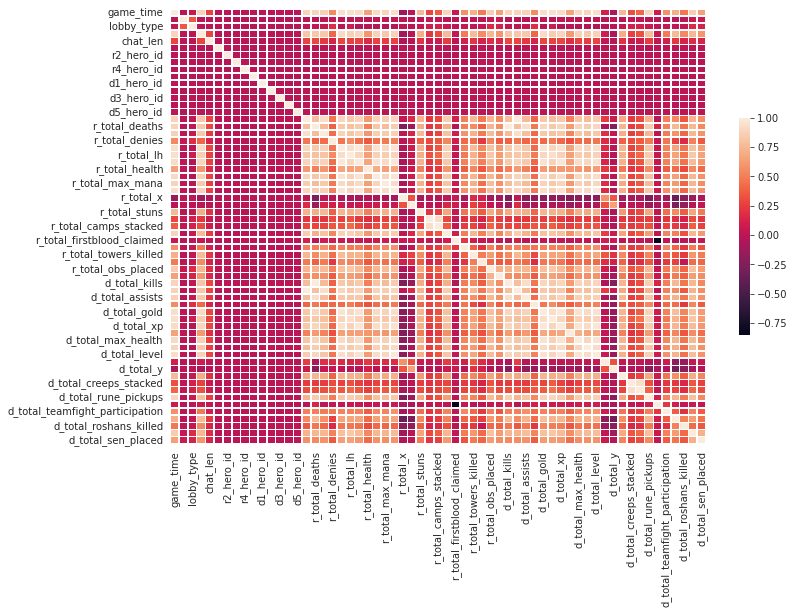

In [65]:
corr_mat = df_train_features_team_group.corr()
sns.heatmap(corr_mat, annot=False, linewidths=0.5, cbar_kws={"shrink": 0.5});

As we can see  - too many columns/features to even see the correlation between stiff.

Highest correlation between:

In [66]:
unstacked_abs_corr = corr_mat.abs().unstack()
unstacked_abs_corr.sort_values()[unstacked_abs_corr.sort_values() < 1][-20:]

r_total_xp          r_total_max_health    0.957840
r_total_max_health  r_total_xp            0.957840
d_total_xp          d_total_max_health    0.959771
d_total_max_health  d_total_xp            0.959771
r_total_xp          d_total_xp            0.971984
d_total_xp          r_total_xp            0.971984
r_total_xp          r_total_level         0.977636
r_total_level       r_total_xp            0.977636
d_total_level       d_total_xp            0.977704
d_total_xp          d_total_level         0.977704
r_total_gold        r_total_xp            0.978610
r_total_xp          r_total_gold          0.978610
d_total_xp          d_total_gold          0.979024
d_total_gold        d_total_xp            0.979024
d_total_level       r_total_level         0.979886
r_total_level       d_total_level         0.979886
d_total_deaths      r_total_kills         0.997510
r_total_kills       d_total_deaths        0.997510
r_total_deaths      d_total_kills         0.997693
d_total_kills       r_total_dea

Possible models for Hero IDs:

* 1. OneHotEncoding + logclassificaiton
* 2. CatBoostClassifier
* 3. Winrate and any other model


## Trying out OneHotEncoding + logclassification

### OneHotEncoding

OneHotEncoding for the whole group:

In [114]:
cat_features = [col for i, col in enumerate(df_train_features_team_group) if col.endswith("hero_id")]
ohe_df = pd.get_dummies(df_train_features_team_group, columns=cat_features)
teams = ['r', 'd']
for team in teams:
    for hero in un_hero_id:
        combine_cols = [col for i, col in enumerate(ohe_df) if col.startswith(team) and col.endswith("hero_id_" + str(hero))]
        ohe_df[team + "_hero_id_" + str(hero)] = ohe_df[combine_cols].sum(axis=1)
        ohe_df.drop(columns=combine_cols, inplace=True)

In [116]:
X = ohe_df.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [117]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [118]:
# classification

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = LogisticRegression(max_iter=1000)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)


print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')

accuracy_score:	0.7253
precision_score:0.7295
recall_score: 	0.7206
f1_score: 	0.7208


In [119]:
clf.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [133]:
from sklearn.model_selection import GridSearchCV

parameters = [{'penalty': ['none', 'l2'],  # l1 not supported
               'C': [0.01,0.1,1],
              "n_jobs": [-1],
              "solver": ["saga"]}]

grid = GridSearchCV(clf, parameters, cv=3, scoring='roc_auc', verbose=3)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END C=0.01, n_jobs=-1, penalty=none, solver=saga;, score=0.810 total time= 1.3min
[CV 2/3] END C=0.01, n_jobs=-1, penalty=none, solver=saga;, score=0.811 total time= 1.2min
[CV 3/3] END C=0.01, n_jobs=-1, penalty=none, solver=saga;, score=0.811 total time= 1.2min
[CV 1/3] END C=0.01, n_jobs=-1, penalty=l2, solver=saga;, score=0.810 total time= 1.3min
[CV 2/3] END C=0.01, n_jobs=-1, penalty=l2, solver=saga;, score=0.811 total time= 1.2min
[CV 3/3] END C=0.01, n_jobs=-1, penalty=l2, solver=saga;, score=0.811 total time= 1.2min
[CV 1/3] END C=0.1, n_jobs=-1, penalty=none, solver=saga;, score=0.810 total time= 1.3min
[CV 2/3] END C=0.1, n_jobs=-1, penalty=none, solver=saga;, score=0.811 total time= 1.2min
[CV 3/3] END C=0.1, n_jobs=-1, penalty=none, solver=saga;, score=0.811 total time= 1.2min
[CV 1/3] END C=0.1, n_jobs=-1, penalty=l2, solver=saga;, score=0.810 total time= 1.3min
[CV 2/3] END C=0.1, n_jobs=-1, penalty=l2,

In [134]:
# классификатор
y_pred_log = grid.best_estimator_.predict(X_valid)

In [136]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
cv_scores = cross_val_score(grid.best_estimator_, X, y, cv=cv, scoring="roc_auc")

In [137]:
print(f'Mean cross validation score: {round(cv_scores.mean(), 4)}')

print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred_log), 4)}')
print(f'precision_score:{round(precision_score(y_valid, y_pred_log, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_valid, y_pred_log, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_valid, y_pred_log, average="macro"), 4)}')

Mean cross validation score: 0.8089
accuracy_score:	0.7207
precision_score:0.7256
recall_score: 	0.7156
f1_score: 	0.7156


Take only gold and hero IDs:

In [139]:
selec_col = [col for i, col in enumerate(ohe_df) if col.endswith("hero_id") or col.endswith("total_gold")]
ohe_df_gold = ohe_df[selec_col]

In [140]:
ohe_df_gold

,r_total_gold,d_total_gold
match_id_hash,,
b9c57c450ce74a2af79c9ce96fac144d,18172,13144
6db558535151ea18ca70a6892197db41,880,480
19c39fe2af2b547e48708ca005c6ae74,2947,1843
c96d629dc0c39f0c616d1949938a6ba6,23650,20819
156c88bff4e9c4668b0f53df3d870f1b,12628,13418
...,...,...
b794aa55646841a03c7783226e6f6bc8,85043,98749
308faee28efee2e66b39f9f2ba6ea9cf,85925,73694
6066cc7417b43c749d551e123d00f0c8,21706,26154


In [147]:
X = ohe_df_gold.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [148]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [149]:
# classification

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = LogisticRegression(C=0.1, max_iter=1000, n_jobs=-1, solver='saga')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)


print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')

accuracy_score:	0.7131
precision_score:0.7125
recall_score: 	0.7114
f1_score: 	0.7117


In [150]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc")


In [151]:
print(f'Mean cross validation score: {round(cv_scores.mean(), 4)}')

print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred_log), 4)}')
print(f'precision_score:{round(precision_score(y_valid, y_pred_log, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_valid, y_pred_log, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_valid, y_pred_log, average="macro"), 4)}')

Mean cross validation score: 0.7988
accuracy_score:	0.7207
precision_score:0.7256
recall_score: 	0.7156
f1_score: 	0.7156


## Trying out CatBoostClassifier without Win-Rate 

## <left>In this case, only CatBoosstClassifier can be used
    
    

In [325]:
filter_col = [col for i, col in enumerate(df_train_features_team_group) if col.endswith("hero_id")]
df_train_features_team_group[filter_col] = df_train_features_team_group[filter_col].astype(str)
X = df_train_features_team_group.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [326]:
cat_features = [i for i, col in enumerate(df_train_features_team_group) if col.endswith("hero_id")]


In [327]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

CatBoostClassifier: 0.807
accuracy_score:	0.7251
precision_score:0.7253
recall_score: 	0.7226
f1_score: 	0.723


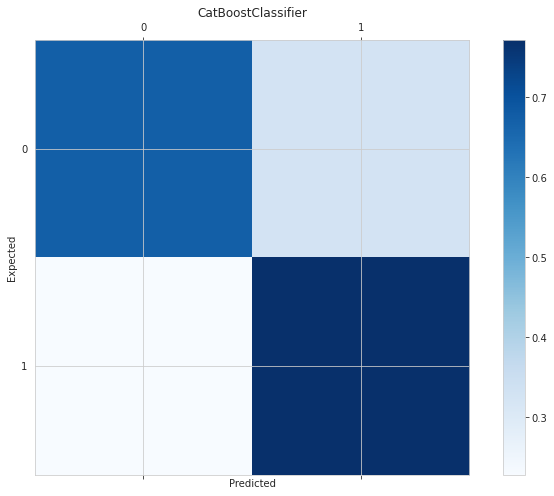

In [328]:
from sklearn.metrics import confusion_matrix

cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
models = [("CAT", cat)]

for model in models:
    model[1].fit(X_train, y_train, cat_features=cat_features)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

In [335]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")
df_test_features_group = team_transformation(df_test_features, total=True, mean=False, std=False, max_=False, min_=False)
# df_test_win_rate = replace_win_rate(df_test_features_group, hero_win_rate)
df_test_features_group[filter_col] = df_test_features_group[filter_col].astype(str)


In [336]:
X_test = df_test_features_group.values

y_test_pred = cat.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [337]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_20-45-07.csv


Score: 0.82624

In [156]:
from sklearn.metrics import confusion_matrix

lgbm = lightgbm.LGBMClassifier(random_state=SEED)
models = [("LGBM", lgbm)]

params = {
    "metric" : "auc", 
    "num_threads" : -1,
    "learning_rate" : 0.01,
    "subsample_freq" : 5,
    "verbosity" : -1
    }

lgtrain = lightgbm.Dataset(X_train, y_train,categorical_feature=cat_features)
cv_result = lightgbm.cv(params,
                       lgtrain,
                       10000,
                       early_stopping_rounds=300,
                       stratified=True,
                       nfold=5)

In [157]:
cv_result['auc-mean'][-1]

0.7869942791623771

## Trying out with the dataframe with win rate replacement and grouping of variables

## <left>Taking the first model from the beginning

In [158]:
X = df_train_features_team_group_win_rate.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [159]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

Win rate seems to make the classifier better.

CatBoostClassifier: 0.8248
accuracy_score:	0.7365
precision_score:0.7363
recall_score: 	0.7344
f1_score: 	0.7349


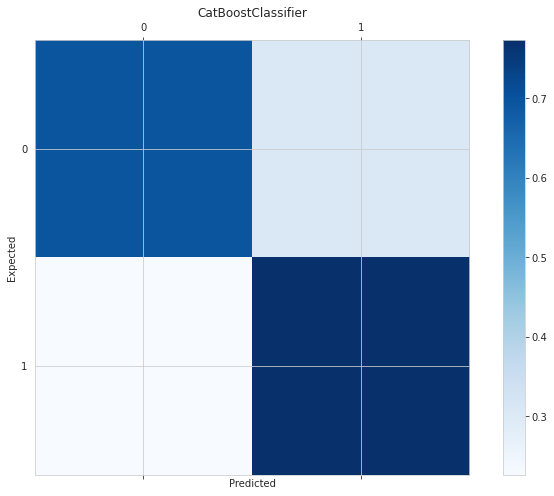

LGBMClassifier: 0.8163
accuracy_score:	0.7297
precision_score:0.7295
recall_score: 	0.7274
f1_score: 	0.7279


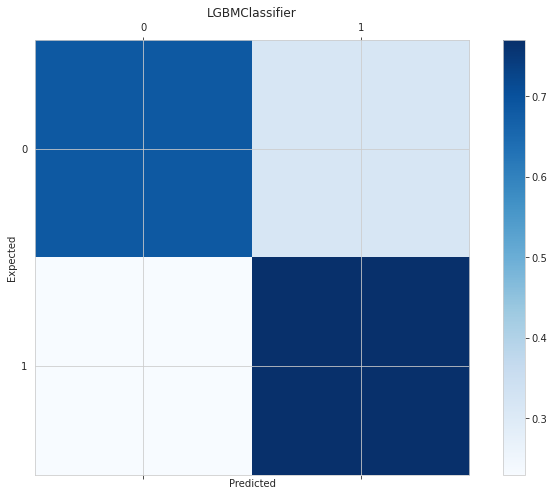

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagg

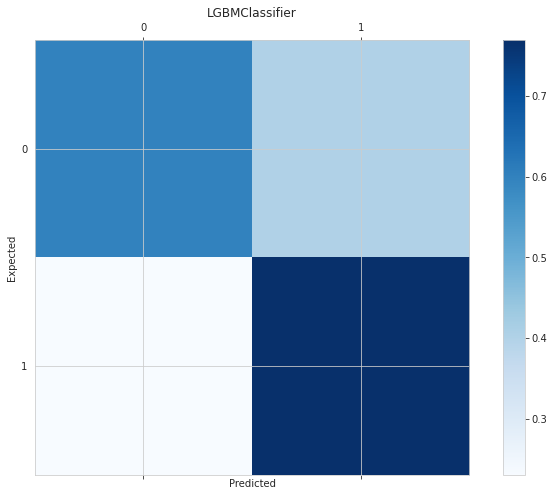

XGBClassifier: 0.8079
accuracy_score:	0.722
precision_score:0.7214
recall_score: 	0.7204
f1_score: 	0.7207


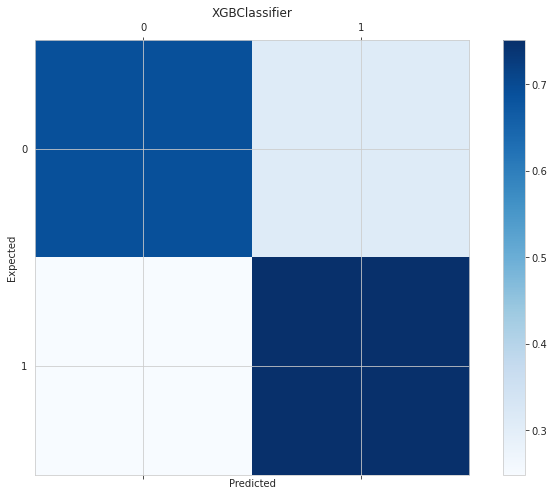

XGBRFClassifier: 0.7631
accuracy_score:	0.6861
precision_score:0.6903
recall_score: 	0.6805
f1_score: 	0.6797


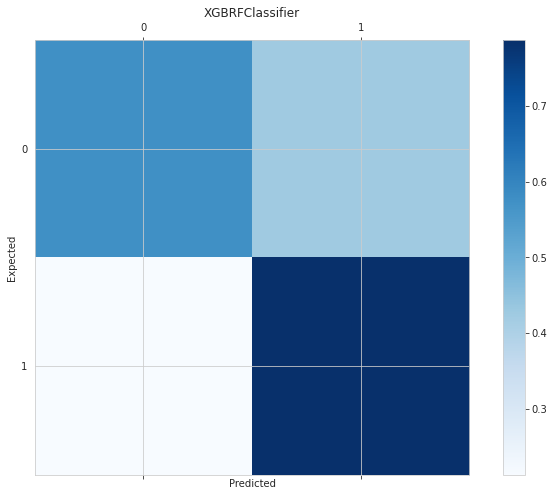

In [160]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED, verbosity = 0)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)

models = [("CAT", cat), 
          ("LGBM", lgbm), 
          ("LGBM_RF", lgbm_rf), 
          ("XGB", xgb), 
          ("XGB_RF", xgb_rf)]

for model in models:
    model[1].fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

**After trying out some of these models, I feel like CatBoostClassifier is the best one.**

In [199]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")
df_test_features_group = team_transformation(df_test_features, total=True, mean=False, std=False, max_=False, min_=False)
df_test_win_rate = replace_win_rate(df_test_features_group, hero_win_rate)
df_test_win_rate

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,d_total_stuns,d_total_creeps_stacked,d_total_camps_stacked,d_total_rune_pickups,d_total_firstblood_claimed,d_total_teamfight_participation,d_total_towers_killed,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0.473713,0.516029,0.504202,0.495822,0.483380,...,0.299948,0,0,7,1,2.00000,0,0,1,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,0.504202,0.530687,0.522029,0.488838,0.506567,...,13.663390,6,2,11,0,1.00000,0,0,3,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0.545796,0.520068,0.528971,0.478618,0.464957,...,26.826797,2,1,8,0,1.50000,0,0,0,0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,0.504766,0.487390,0.486572,0.468254,0.478618,...,4.632218,0,0,15,1,2.50000,0,0,4,1
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,0.521045,0.528893,0.578789,0.504202,0.478618,...,12.830091,9,2,16,0,2.00000,0,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,0.472096,0.498474,0.507140,0.451797,0.478618,...,5.598577,3,2,3,0,1.00000,0,0,2,0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,0.528893,0.478618,0.483508,0.491272,0.530687,...,300.799313,0,0,62,1,2.18750,4,2,18,6
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,0.510832,0.518550,0.480507,0.495150,0.503371,...,70.816496,6,2,34,0,2.71875,3,0,11,6


In [200]:
X_test = df_test_win_rate.values

y_test_pred = cat.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [201]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_19-27-13.csv


**very low score**

Let me try splitting on train and test

In [427]:
df_train_features_team_group.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
       'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id',
       'r_total_kills', 'r_total_deaths', 'r_total_assists', 'r_total_denies',
       'r_total_gold', 'r_total_lh', 'r_total_xp', 'r_total_health',
       'r_total_max_health', 'r_total_max_mana', 'r_total_level', 'r_total_x',
       'r_total_y', 'r_total_stuns', 'r_total_creeps_stacked',
       'r_total_camps_stacked', 'r_total_rune_pickups',
       'r_total_firstblood_claimed', 'r_total_teamfight_participation',
       'r_total_towers_killed', 'r_total_roshans_killed', 'r_total_obs_placed',
       'r_total_sen_placed', 'd_total_kills', 'd_total_deaths',
       'd_total_assists', 'd_total_denies', 'd_total_gold', 'd_total_lh',
       'd_total_xp', 'd_total_health', 'd_total_max_health',
       'd_total_max_mana', 'd_total_level', 'd_total_x', 'd_total_y',
  

In [428]:
X = df_train_features_team_group.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [429]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train_features_team_group, df_train_targets["radiant_win"], 
                                                      test_size=0.3, 
                                                      random_state=SEED)


In [430]:
hero_win_rate = calc_win_rate(X_train, y_train)
df_X_train_win_rate = replace_win_rate(X_train, hero_win_rate)
df_X_valid_win_rate = replace_win_rate(X_valid, hero_win_rate)

In [431]:
X_train = df_X_train_win_rate.values
X_valid = df_X_valid_win_rate.values
y_train = y_train.values.astype("int8")
y_valid = y_valid.values.astype("int8")

CatBoostClassifier: 0.807
accuracy_score:	0.7347
precision_score:0.7345
recall_score: 	0.7326
f1_score: 	0.7331


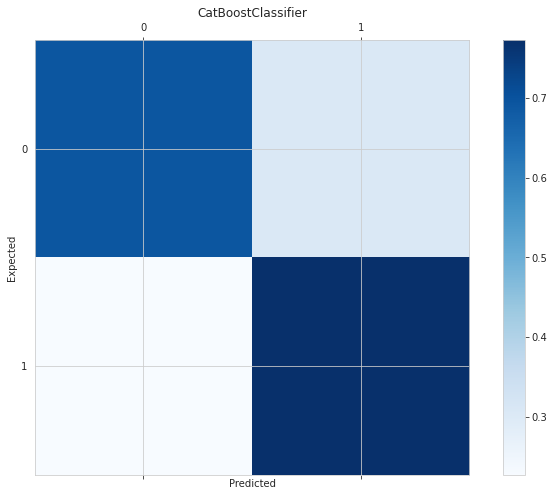

In [432]:
cat_ext = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
models = [("CAT", cat_ext)]

for model in models:
    model[1].fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

In [433]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")
df_test_features_group = team_transformation(df_test_features, total=True, mean=False, std=False, max_=False, min_=False)
df_test_win_rate = replace_win_rate(df_test_features_group, hero_win_rate)
df_test_win_rate

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,d_total_stuns,d_total_creeps_stacked,d_total_camps_stacked,d_total_rune_pickups,d_total_firstblood_claimed,d_total_teamfight_participation,d_total_towers_killed,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0.478771,0.532544,0.500860,0.496883,0.479520,...,0.299948,0,0,7,1,2.00000,0,0,1,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,0.500860,0.533477,0.526891,0.485652,0.499213,...,13.663390,6,2,11,0,1.00000,0,0,3,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0.542066,0.518677,0.525140,0.484259,0.453865,...,26.826797,2,1,8,0,1.50000,0,0,0,0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,0.506521,0.480401,0.482728,0.460628,0.484259,...,4.632218,0,0,15,1,2.50000,0,0,4,1
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,0.529527,0.522663,0.578174,0.500860,0.484259,...,12.830091,9,2,16,0,2.00000,0,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,0.462279,0.501471,0.500278,0.457213,0.484259,...,5.598577,3,2,3,0,1.00000,0,0,2,0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,0.522663,0.484259,0.491215,0.482767,0.533477,...,300.799313,0,0,62,1,2.18750,4,2,18,6
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,0.510467,0.526944,0.478078,0.497983,0.499029,...,70.816496,6,2,34,0,2.71875,3,0,11,6


In [435]:
X_test = df_test_win_rate.values

y_test_pred = cat_ext.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [436]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_21-42-55.csv


Score: 0.83537

In [314]:
df_test_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,8.664527,3,1,3,0,0.000000,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.000000,2,1,2,0,0.250000,0,0,0,0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,0.000000,0,0,1,0,0.125000,0,0,0,0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,0.766459,0,0,1,0,1.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,2,0,0,1,...,0.000000,3,2,0,0,0.000000,0,0,0,0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,2,9,1,6,...,149.551700,0,0,20,0,0.395833,0,0,4,0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,1,9,9,0,...,26.493834,6,2,3,0,0.562500,0,0,7,2


In [463]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

# Скопируем таблицу с признаками
df_test_features_extended = df_test_features.copy()

# Добавим новые
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [464]:
df_test_features_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d4_actions,d4_num_ab_upg,d4_num_purch,d5_damage,d5_damage_taken,d5_item_uses,d5_ability_uses,d5_actions,d5_num_ab_upg,d5_num_purch
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,167.0,0.0,9.0,2332.0,681.0,3.0,4.0,819.0,0.0,6.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,3093.0,2.0,18.0,3955.0,3317.0,11.0,19.0,3924.0,3.0,13.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,688.0,2.0,9.0,10739.0,2785.0,6.0,9.0,1218.0,2.0,7.0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,4605.0,4.0,19.0,15255.0,5052.0,10.0,7.0,1914.0,7.0,14.0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,2179.0,7.0,15.0,16086.0,5782.0,11.0,64.0,1822.0,5.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,2,0,0,1,...,1223.0,4.0,7.0,15720.0,694.0,20.0,0.0,960.0,2.0,5.0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,2,9,1,6,...,4440.0,18.0,35.0,61435.0,17065.0,34.0,112.0,4812.0,17.0,41.0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,1,9,9,0,...,4906.0,16.0,28.0,26995.0,7794.0,19.0,58.0,4414.0,11.0,30.0


In [319]:
df_test_extended_win_rate = replace_win_rate(df_test_extended_group, hero_win_rate)

In [323]:
hero_win_rate

{15: 0.4793577981651376,
 101: 0.5220289855072464,
 57: 0.5329623287671232,
 119: 0.5039661554732946,
 12: 0.5053340819764177,
 74: 0.49515018773466835,
 71: 0.517799352750809,
 35: 0.49730200174064404,
 30: 0.5047659394196145,
 26: 0.48883815322171487,
 10: 0.4669260700389105,
 8: 0.5210453920220083,
 39: 0.4587443946188341,
 103: 0.534375,
 86: 0.46825396825396826,
 44: 0.4912722692100054,
 41: 0.5065669463699379,
 9: 0.46546261089987323,
 23: 0.485475249825703,
 64: 0.523574144486692,
 16: 0.4720961281708945,
 56: 0.5369928400954654,
 99: 0.5306874864454565,
 42: 0.5457957957957958,
 120: 0.4663716814159292,
 40: 0.4892769607843137,
 1: 0.4728476821192053,
 11: 0.4737128551213671,
 2: 0.502353310323188,
 84: 0.5232273838630807,
 62: 0.48304383788254757,
 4: 0.509170305676856,
 14: 0.5042023169531309,
 108: 0.5505310037684138,
 58: 0.47363636363636363,
 5: 0.5185887708649469,
 76: 0.5288926843153999,
 51: 0.5272140221402214,
 81: 0.5412691829116549,
 37: 0.5389435989256938,
 48: 0.52

In [324]:
df_test_extended_group

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed,d_total_num_purch,d_total_damage,d_total_damage_taken,d_total_item_uses,d_total_ability_uses,d_total_actions,d_total_num_ab_upg
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,78,14,59,77,...,0,1,0,35.0,9445.0,1555.0,12.0,11.0,2756.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,99,101,26,41,...,0,3,0,73.0,69031.0,22808.0,65.0,82.0,11299.0,16.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,69,27,104,65,...,0,0,0,40.0,54223.0,9404.0,35.0,70.0,4581.0,11.0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,95,34,86,104,...,0,4,1,93.0,72194.0,22461.0,97.0,101.0,12498.0,27.0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,76,32,14,104,...,0,3,2,81.0,99694.0,21226.0,67.0,162.0,10277.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,111,18,97,104,...,0,2,0,47.0,63427.0,14730.0,68.0,56.0,8572.0,19.0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,104,114,44,99,...,2,18,6,219.0,524181.0,135446.0,331.0,534.0,17528.0,87.0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,49,7,74,63,...,0,11,6,146.0,299117.0,79933.0,213.0,375.0,26536.0,67.0


In [320]:
df_test_extended_win_rate

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed,d_total_num_purch,d_total_damage,d_total_damage_taken,d_total_item_uses,d_total_ability_uses,d_total_actions,d_total_num_ab_upg
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0.473713,0.516029,0.504202,0.495822,0.483380,...,0,1,0,35.0,9445.0,1555.0,12.0,11.0,2756.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,0.504202,0.530687,0.522029,0.488838,0.506567,...,0,3,0,73.0,69031.0,22808.0,65.0,82.0,11299.0,16.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0.545796,0.520068,0.528971,0.478618,0.464957,...,0,0,0,40.0,54223.0,9404.0,35.0,70.0,4581.0,11.0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,0.504766,0.487390,0.486572,0.468254,0.478618,...,0,4,1,93.0,72194.0,22461.0,97.0,101.0,12498.0,27.0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,0.521045,0.528893,0.578789,0.504202,0.478618,...,0,3,2,81.0,99694.0,21226.0,67.0,162.0,10277.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,0.472096,0.498474,0.507140,0.451797,0.478618,...,0,2,0,47.0,63427.0,14730.0,68.0,56.0,8572.0,19.0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,0.528893,0.478618,0.483508,0.491272,0.530687,...,2,18,6,219.0,524181.0,135446.0,331.0,534.0,17528.0,87.0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,0.510832,0.518550,0.480507,0.495150,0.503371,...,0,11,6,146.0,299117.0,79933.0,213.0,375.0,26536.0,67.0


In [385]:
def team_transformation_extended(df, total=True, mean=True, std=True, max_=True, min_=True):
    df_transf = df.copy()
    
    teams = ['r', 'd']
    team_features = [
     'kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y',
     'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
     'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed',
     'num_purch', 'damage', 'damage_taken',
     'item_uses', 'ability_uses', 'actions',
    'num_ab_upg'
    ]
    
    for team in teams:
        for feature in team_features:
            if feature != 'health':
                filter_col = [col for col in df_transf if col.endswith(feature) and col.startswith(team)]
            else:
                filter_col = [col for col in df_transf if col.endswith(feature) and col.startswith(team) and not col.endswith("max_health")]
            
            if total:
                df_transf[team + "_total_" + feature] = df_transf[filter_col].sum(axis=1)
            
            if mean:
                df_transf[team + "mean_" + feature] = df_transf[filter_col].mean(axis=1)
            
            if std:
                df_transf[team + "std_" + feature] = df_transf[filter_col].std(axis=1)
                
            if max_:
                df_transf[team + "max_" + feature] = df_transf[filter_col].max(axis=1)

            if min_:
                df_transf[team + "min_" + feature] = df_transf[filter_col].min(axis=1)
            
            df_transf.drop(columns=filter_col, inplace=True)
            
    return df_transf

# Extended features without win-rate

In [384]:
df_extended_group.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
       'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id',
       'r_total_kills', 'r_total_deaths', 'r_total_assists', 'r_total_denies',
       'r_total_gold', 'r_total_lh', 'r_total_xp', 'r_total_health',
       'r_total_max_health', 'r_total_max_mana', 'r_total_level', 'r_total_x',
       'r_total_y', 'r_total_stuns', 'r_total_creeps_stacked',
       'r_total_camps_stacked', 'r_total_rune_pickups',
       'r_total_firstblood_claimed', 'r_total_teamfight_participation',
       'r_total_towers_killed', 'r_total_roshans_killed', 'r_total_obs_placed',
       'r_total_sen_placed', 'r_total_num_purch', 'r_total_damage',
       'r_total_damage_taken', 'r_total_item_uses', 'r_total_ability_uses',
       'r_total_actions', 'r_total_num_ab_upg', 'd_total_kills',
       'd_total_deaths', 'd_total_assists', 'd_total_denies', 

In [386]:
df_extended_group = team_transformation_extended(df_train_features_extended_players, total=True, mean=False, std=False, max_=False, min_=False)
filter_col = [col for i, col in enumerate(df_extended_group) if col.endswith("hero_id")]
df_extended_group[filter_col] = df_extended_group[filter_col].astype(str)
X = df_extended_group.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [387]:
cat_features = [i for i, col in enumerate(df_train_features_team_group) if col.endswith("hero_id")]


In [388]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

CatBoostClassifier: 0.8081
accuracy_score:	0.7253
precision_score:0.7255
recall_score: 	0.7228
f1_score: 	0.7233


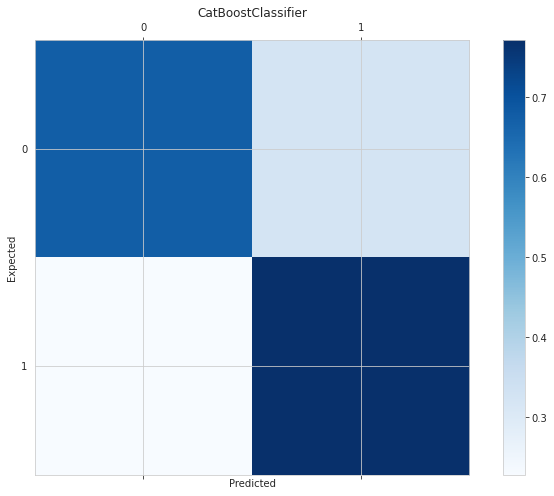

In [392]:
from sklearn.metrics import confusion_matrix

cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
models = [("CAT", cat)]

cat.fit(X_train, y_train, cat_features=cat_features)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
print(f"{cat.__class__.__name__}: {round(cv_scores.mean(), 4)}")

y_pred = cat.predict(X_valid)
print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')


conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
# print('Confusion matrix:\n', conf_mat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.title(model[1].__class__.__name__)
plt.show()

In [393]:
df_test_extended_group = team_transformation_extended(df_test_features_extended, total=True, mean=False, std=False, max_=False, min_=False)
# df_test_win_rate = replace_win_rate(df_test_features_group, hero_win_rate)
filter_col = [col for i, col in enumerate(df_test_extended_group) if col.endswith("hero_id")]
df_test_extended_group[filter_col] = df_test_extended_group[filter_col].astype(str)

In [394]:
X_test = df_test_extended_group.values

y_test_pred = cat.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [395]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_21-22-33.csv


# Extended group with win-rate

In [438]:
df_extended_group = team_transformation_extended(df_train_features_extended_players, total=True, mean=False, std=False, max_=False, min_=False)

In [447]:
X_train, X_valid, y_train, y_valid = train_test_split(df_extended_group, df_train_targets["radiant_win"], 
                                                      test_size=0.3, 
                                                      random_state=SEED)


In [448]:
hero_win_rate = calc_win_rate(X_train, y_train)
df_X_train_win_rate = replace_win_rate(X_train, hero_win_rate)
df_X_valid_win_rate = replace_win_rate(X_valid, hero_win_rate)

In [449]:
X_train = df_X_train_win_rate.values
X_valid = df_X_valid_win_rate.values
y_train = y_train.values.astype("int8")
y_valid = y_valid.values.astype("int8")

CatBoostClassifier: 0.8081
accuracy_score:	0.737
precision_score:0.7368
recall_score: 	0.735
f1_score: 	0.7355


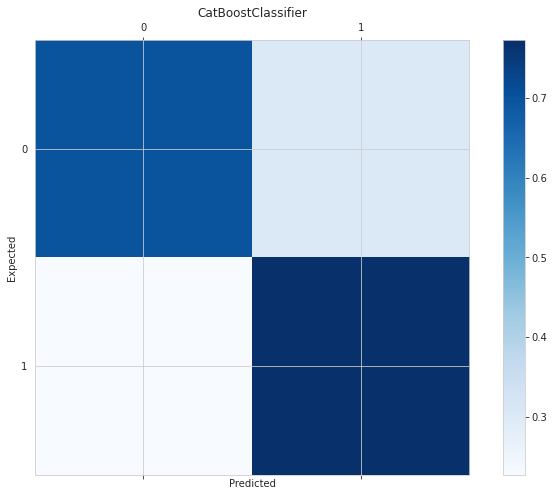

In [450]:
cat_ext_all = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
models = [("CAT", cat_ext_all)]

for model in models:
    model[1].fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

In [471]:
df_test_extended_group = team_transformation_extended(df_test_features_extended, total=True, mean=False, std=False, max_=False, min_=False)
# df_test_win_rate = replace_win_rate(df_test_features_group, hero_win_rate)
df_test_extended_win_rate = replace_win_rate(df_test_extended_group, hero_win_rate)
df_test_extended_win_rate

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed,d_total_num_purch,d_total_damage,d_total_damage_taken,d_total_item_uses,d_total_ability_uses,d_total_actions,d_total_num_ab_upg
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0.478771,0.532544,0.500860,0.496883,0.479520,...,0,1,0,35.0,9445.0,1555.0,12.0,11.0,2756.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,0.500860,0.533477,0.526891,0.485652,0.499213,...,0,3,0,73.0,69031.0,22808.0,65.0,82.0,11299.0,16.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0.542066,0.518677,0.525140,0.484259,0.453865,...,0,0,0,40.0,54223.0,9404.0,35.0,70.0,4581.0,11.0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,0.506521,0.480401,0.482728,0.460628,0.484259,...,0,4,1,93.0,72194.0,22461.0,97.0,101.0,12498.0,27.0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,0.529527,0.522663,0.578174,0.500860,0.484259,...,0,3,2,81.0,99694.0,21226.0,67.0,162.0,10277.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,0.462279,0.501471,0.500278,0.457213,0.484259,...,0,2,0,47.0,63427.0,14730.0,68.0,56.0,8572.0,19.0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,0.522663,0.484259,0.491215,0.482767,0.533477,...,2,18,6,219.0,524181.0,135446.0,331.0,534.0,17528.0,87.0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,0.510467,0.526944,0.478078,0.497983,0.499029,...,0,11,6,146.0,299117.0,79933.0,213.0,375.0,26536.0,67.0


In [472]:
X_test = df_test_extended_win_rate.values

y_test_pred = cat_ext_all.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [473]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_21-59-56.csv


Score: 0.83380

Got worse.


## Dropping Columns that are not needed:

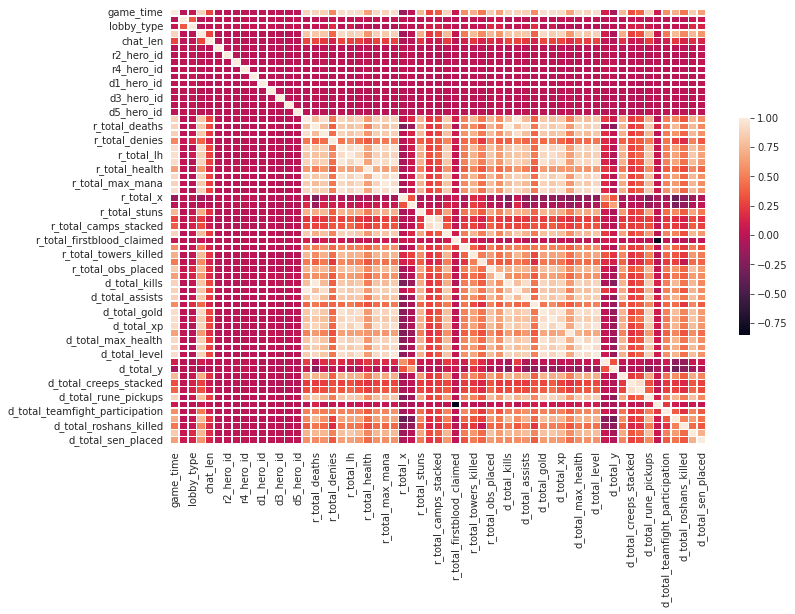

In [172]:
corr_mat = df_train_features_team_group_win_rate.corr()
sns.heatmap(corr_mat, annot=False, linewidths=0.5, cbar_kws={"shrink": 0.5});

As we can see  - too many columns/features to even see the correlation between stiff.

Highest correlation between:

In [173]:
unstacked_abs_corr = corr_mat.abs().unstack()
unstacked_abs_corr.sort_values()[unstacked_abs_corr.sort_values() < 1][-20:]

r_total_xp          r_total_max_health    0.957840
r_total_max_health  r_total_xp            0.957840
d_total_xp          d_total_max_health    0.959771
d_total_max_health  d_total_xp            0.959771
r_total_xp          d_total_xp            0.971984
d_total_xp          r_total_xp            0.971984
r_total_xp          r_total_level         0.977636
r_total_level       r_total_xp            0.977636
d_total_level       d_total_xp            0.977704
d_total_xp          d_total_level         0.977704
r_total_gold        r_total_xp            0.978610
r_total_xp          r_total_gold          0.978610
d_total_xp          d_total_gold          0.979024
d_total_gold        d_total_xp            0.979024
d_total_level       r_total_level         0.979886
r_total_level       d_total_level         0.979886
d_total_deaths      r_total_kills         0.997510
r_total_kills       d_total_deaths        0.997510
r_total_deaths      d_total_kills         0.997693
d_total_kills       r_total_dea

Observations from playing the game:
* levels matter more than game time
* kills matter more than assists
* gold matters the most
* xp obviously directly correlated with level and gold, would leave it out
* lh - units killed (sth like minions)

In [175]:
df_train_features_team_group_win_rate.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
       'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id',
       'r_total_kills', 'r_total_deaths', 'r_total_assists', 'r_total_denies',
       'r_total_gold', 'r_total_lh', 'r_total_xp', 'r_total_health',
       'r_total_max_health', 'r_total_max_mana', 'r_total_level', 'r_total_x',
       'r_total_y', 'r_total_stuns', 'r_total_creeps_stacked',
       'r_total_camps_stacked', 'r_total_rune_pickups',
       'r_total_firstblood_claimed', 'r_total_teamfight_participation',
       'r_total_towers_killed', 'r_total_roshans_killed', 'r_total_obs_placed',
       'r_total_sen_placed', 'd_total_kills', 'd_total_deaths',
       'd_total_assists', 'd_total_denies', 'd_total_gold', 'd_total_lh',
       'd_total_xp', 'd_total_health', 'd_total_max_health',
       'd_total_max_mana', 'd_total_level', 'd_total_x', 'd_total_y',
  

In [194]:
def drop_unnecessary_cols(df, unnecessary_columns):
    df_dropped = df.drop(columns=unnecessary_columns)
    return df_dropped

In [183]:
unnecessary_columns = ['game_mode', 'lobby_type', 'objectives_len', 'chat_len']

df_dropped = drop_unnecessary_cols(df_train_features_team_group_win_rate)
df_dropped

,game_time,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,...,d_total_stuns,d_total_creeps_stacked,d_total_camps_stacked,d_total_rune_pickups,d_total_firstblood_claimed,d_total_teamfight_participation,d_total_towers_killed,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,0.479358,0.545319,0.528971,0.503371,0.474359,0.473636,0.504202,0.472848,0.536993,...,3.532506,3,2,14,1,1.500000,0,0,5,2
6db558535151ea18ca70a6892197db41,21,0.522029,0.527214,0.491272,0.518550,0.445614,0.507140,0.577586,0.515546,0.489277,...,0.000000,0,0,1,0,0.000000,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,0.532962,0.466926,0.541269,0.447745,0.503966,0.521183,0.532309,0.497850,0.552333,...,0.000000,0,0,0,0,0.000000,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,0.503966,0.517799,0.491272,0.497302,0.550531,0.515546,0.447745,0.488838,0.478618,...,48.488246,0,0,12,0,2.000000,0,0,7,1
156c88bff4e9c4668b0f53df3d870f1b,582,0.505334,0.518550,0.400759,0.483508,0.485303,0.527214,0.515546,0.521183,0.503966,...,46.016229,6,2,12,1,2.000000,1,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,0.530687,0.467043,0.489277,0.577586,0.443043,0.504202,0.468254,0.497717,0.521183,...,245.646882,4,2,57,0,3.000000,9,2,17,5
308faee28efee2e66b39f9f2ba6ea9cf,2525,0.572719,0.503371,0.545796,0.490237,0.578789,0.461486,0.495822,0.527214,0.413226,...,76.361084,6,2,45,1,1.736842,3,1,17,20
6066cc7417b43c749d551e123d00f0c8,1002,0.472848,0.505334,0.515546,0.545796,0.435476,0.506567,0.503966,0.530687,0.523574,...,81.713846,0,0,28,1,2.500000,0,0,2,0


In [186]:
X = df_dropped.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [187]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

CatBoostClassifier: 0.8249
accuracy_score:	0.7385
precision_score:0.7381
recall_score: 	0.7366
f1_score: 	0.7371


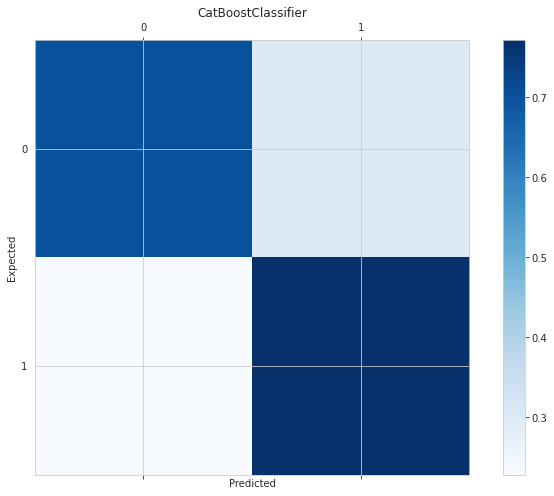

In [188]:
from sklearn.metrics import confusion_matrix

cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
models = [("CAT", cat)]

for model in models:
    model[1].fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

Model got better. Now let's continue removing some columns that correlate highly with each other and see what happens:

In [205]:
df_train_features_team_group_win_rate.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
       'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id',
       'r_total_kills', 'r_total_deaths', 'r_total_assists', 'r_total_denies',
       'r_total_gold', 'r_total_lh', 'r_total_xp', 'r_total_health',
       'r_total_max_health', 'r_total_max_mana', 'r_total_level', 'r_total_x',
       'r_total_y', 'r_total_stuns', 'r_total_creeps_stacked',
       'r_total_camps_stacked', 'r_total_rune_pickups',
       'r_total_firstblood_claimed', 'r_total_teamfight_participation',
       'r_total_towers_killed', 'r_total_roshans_killed', 'r_total_obs_placed',
       'r_total_sen_placed', 'd_total_kills', 'd_total_deaths',
       'd_total_assists', 'd_total_denies', 'd_total_gold', 'd_total_lh',
       'd_total_xp', 'd_total_health', 'd_total_max_health',
       'd_total_max_mana', 'd_total_level', 'd_total_x', 'd_total_y',
  

In [219]:
def replace_features(df):
    df_replaced = df.copy()
    # R

    df_replaced["r_KDA"] = (df["r_total_kills"] + df['r_total_assists'])/df['r_total_deaths']
#     df_replaced['r_Wards'] = (df['r_total_obs_placed'] + df['r_total_sen_placed'])
    
    # D
    df_replaced["d_KDA"] = (df["d_total_kills"] + df['d_total_assists'])/df['d_total_deaths']
#     df_replaced['d_Wards'] = (df['d_total_obs_placed'] + df['d_total_sen_placed'])

    return df_replaced

In [285]:
endings = [
    'total_camps_stacked',
#     'total_creeps_stacked',
#     'total_xp',
    'total_kills',
    'total_deaths',
    'total_assists',
#     'total_denies',
    'total_x',
    'total_y',
    'total_stuns',
#     'total_firstblood_claimed'
#     'total_obs_placed',
#     'total_sen_place'
]

In [286]:
unnecessary_columns = [col for ending in endings for col in df_train_features_team_group if col.endswith(ending)]
unnecessary_columns += ['game_mode', 'lobby_type', 'objectives_len', 'chat_len']

df_replaced = replace_features(df_train_features_team_group_win_rate)

df_dropped = drop_unnecessary_cols(df_replaced, unnecessary_columns)

In [287]:
X = df_dropped.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [288]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

CatBoostClassifier: 0.8233
accuracy_score:	0.7365
precision_score:0.7361
recall_score: 	0.7347
f1_score: 	0.7351


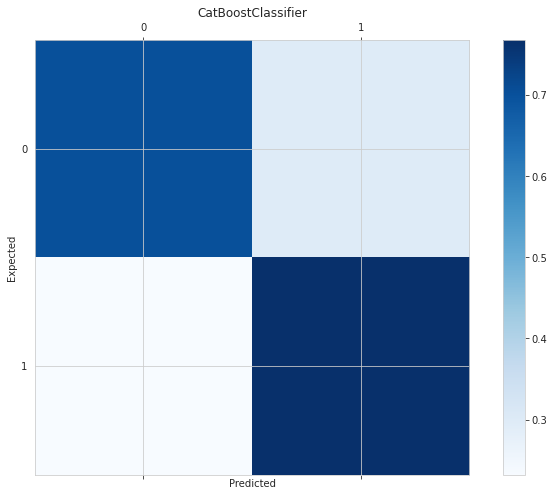

In [289]:
from sklearn.metrics import confusion_matrix

cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
models = [("CAT", cat)]

for model in models:
    model[1].fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

# Trying out with extended features

In [474]:
df_train_features_extended_players.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies',
       ...
       'd9_actions', 'd9_num_ab_upg', 'd9_num_purch', 'd10_damage',
       'd10_damage_taken', 'd10_item_uses', 'd10_ability_uses', 'd10_actions',
       'd10_num_ab_upg', 'd10_num_purch'],
      dtype='object', length=315)

In [475]:
df_extended_group = team_transformation_extended(df_train_features_extended_players, total=True, mean=False, std=False, max_=False, min_=False)

In [476]:
df_extended_group.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
       'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id',
       'r_total_kills', 'r_total_deaths', 'r_total_assists', 'r_total_denies',
       'r_total_gold', 'r_total_lh', 'r_total_xp', 'r_total_health',
       'r_total_max_health', 'r_total_max_mana', 'r_total_level', 'r_total_x',
       'r_total_y', 'r_total_stuns', 'r_total_creeps_stacked',
       'r_total_camps_stacked', 'r_total_rune_pickups',
       'r_total_firstblood_claimed', 'r_total_teamfight_participation',
       'r_total_towers_killed', 'r_total_roshans_killed', 'r_total_obs_placed',
       'r_total_sen_placed', 'r_total_num_purch', 'r_total_damage',
       'r_total_damage_taken', 'r_total_item_uses', 'r_total_ability_uses',
       'r_total_actions', 'r_total_num_ab_upg', 'd_total_kills',
       'd_total_deaths', 'd_total_assists', 'd_total_denies', 

In [487]:
def drop_unnecessary_cols(df, unnecessary_columns):
    df_dropped = df.drop(columns=unnecessary_columns)
    return df_dropped

def replace_features(df):
    df_replaced = df.copy()
    # R

    df_replaced["r_KDA"] = (df["r_total_kills"] + df['r_total_assists'])/df['r_total_deaths']
#     df_replaced['r_Wards'] = (df['r_total_obs_placed'] + df['r_total_sen_placed'])
    
    # D
    df_replaced["d_KDA"] = (df["d_total_kills"] + df['d_total_assists'])/df['d_total_deaths']
#     df_replaced['d_Wards'] = (df['d_total_obs_placed'] + df['d_total_sen_placed'])

    return df_replaced

In [477]:
endings = [
    'total_camps_stacked',
#     'total_creeps_stacked',
#     'total_xp',
    'total_kills',
    'total_deaths',
    'total_assists',
#     'total_denies',
    'total_x',
    'total_y',
    'total_stuns',
#     'total_firstblood_claimed'
#     'total_obs_placed',
#     'total_sen_place',
#     '_num_purch',
    'total_actions'
]

In [489]:
unnecessary_columns = [col for ending in endings for col in df_extended_group if col.endswith(ending)]
unnecessary_columns += ['game_mode', 'lobby_type', 'objectives_len', 'chat_len']

df_replaced = replace_features(df_extended_group)

df_dropped = drop_unnecessary_cols(df_replaced, unnecessary_columns)

df_dropped.columns

Index(['game_time', 'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id',
       'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id',
       'd5_hero_id', 'r_total_denies', 'r_total_gold', 'r_total_lh',
       'r_total_xp', 'r_total_health', 'r_total_max_health',
       'r_total_max_mana', 'r_total_level', 'r_total_creeps_stacked',
       'r_total_rune_pickups', 'r_total_firstblood_claimed',
       'r_total_teamfight_participation', 'r_total_towers_killed',
       'r_total_roshans_killed', 'r_total_obs_placed', 'r_total_sen_placed',
       'r_total_damage', 'r_total_damage_taken', 'r_total_item_uses',
       'r_total_ability_uses', 'r_total_actions', 'r_total_num_ab_upg',
       'd_total_denies', 'd_total_gold', 'd_total_lh', 'd_total_xp',
       'd_total_health', 'd_total_max_health', 'd_total_max_mana',
       'd_total_level', 'd_total_creeps_stacked', 'd_total_rune_pickups',
       'd_total_firstblood_claimed', 'd_total_teamfight_participation',
       'd_total_to

In [490]:
X_train, X_valid, y_train, y_valid = train_test_split(df_dropped, df_train_targets["radiant_win"], 
                                                      test_size=0.3, 
                                                      random_state=SEED)


In [491]:
hero_win_rate = calc_win_rate(X_train, y_train)
df_X_train_win_rate = replace_win_rate(X_train, hero_win_rate)
df_X_valid_win_rate = replace_win_rate(X_valid, hero_win_rate)

In [492]:
X_train = df_X_train_win_rate.values
X_valid = df_X_valid_win_rate.values
y_train = y_train.values.astype("int8")
y_valid = y_valid.values.astype("int8")

CatBoostClassifier: 0.8081
accuracy_score:	0.7327
precision_score:0.7322
recall_score: 	0.731
f1_score: 	0.7313


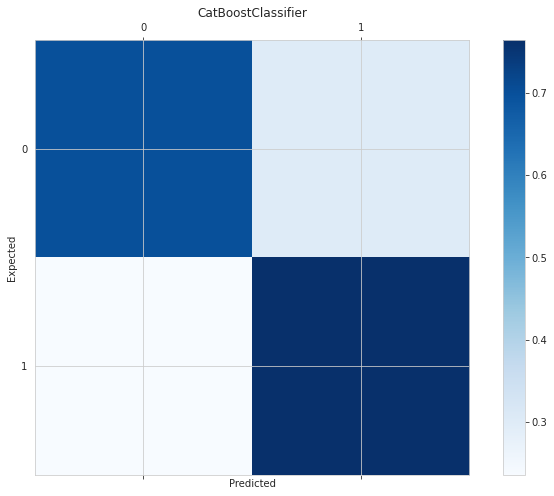

In [493]:
cat_dropped = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
models = [("CAT", cat_dropped)]

for model in models:
    model[1].fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

In [494]:
df_test_extended_group = team_transformation_extended(df_test_features_extended, total=True, mean=False, std=False, max_=False, min_=False)
# df_test_win_rate = replace_win_rate(df_test_features_group, hero_win_rate)
df_test_replaced = replace_features(df_test_extended_group)
df_test_dropped = drop_unnecessary_cols(df_test_replaced, unnecessary_columns)
df_test_extended_win_rate = replace_win_rate(df_test_dropped, hero_win_rate)
df_test_extended_win_rate

,game_time,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,...,d_total_obs_placed,d_total_sen_placed,d_total_damage,d_total_damage_taken,d_total_item_uses,d_total_ability_uses,d_total_actions,d_total_num_ab_upg,r_KDA,d_KDA
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,0.478771,0.532544,0.500860,0.496883,0.479520,0.506472,0.484248,0.479012,0.516843,...,1,0,9445.0,1555.0,12.0,11.0,2756.0,0.0,0.000000,inf
46a0ddce8f7ed2a8d9bd5edcbb925682,576,0.500860,0.533477,0.526891,0.485652,0.499213,0.500278,0.447040,0.529527,0.518677,...,3,0,69031.0,22808.0,65.0,82.0,11299.0,16.0,7.000000,0.285714
b1b35ff97723d9b7ade1c9c3cf48f770,453,0.542066,0.518677,0.525140,0.484259,0.453865,0.484151,0.564495,0.504509,0.449098,...,0,0,54223.0,9404.0,35.0,70.0,4581.0,11.0,1.250000,3.000000
ab3cc6ccac661a1385e73a2e9f21313a,721,0.506521,0.480401,0.482728,0.460628,0.484259,0.459693,0.552239,0.469424,0.525992,...,4,1,72194.0,22461.0,97.0,101.0,12498.0,27.0,1.500000,2.333333
54aaab1cb8cc5df3c253641618673266,752,0.529527,0.522663,0.578174,0.500860,0.484259,0.465587,0.511780,0.552239,0.513562,...,3,2,99694.0,21226.0,67.0,162.0,10277.0,26.0,4.000000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,0.462279,0.501471,0.500278,0.457213,0.484259,0.564495,0.499167,0.524857,0.527970,...,2,0,63427.0,14730.0,68.0,56.0,8572.0,19.0,7.000000,0.250000
06e2b42495855647830ccc6d466f913c,2561,0.522663,0.484259,0.491215,0.482767,0.533477,0.496032,0.525140,0.504396,0.399850,...,18,6,524181.0,135446.0,331.0,534.0,17528.0,87.0,1.791667,2.333333
defd0caeed6ea83d7d5fbdec013fe7d1,1783,0.510467,0.526944,0.478078,0.497983,0.499029,0.500860,0.504396,0.578174,0.529527,...,11,6,299117.0,79933.0,213.0,375.0,26536.0,67.0,1.593750,4.142857


In [496]:
X_test = df_test_extended_win_rate.values

y_test_pred = cat_dropped.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [497]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_22-14-20.csv


Score:
0.82901

In [505]:
endings = [
    'total_kills',
    'total_deaths',
    'total_assists',
    'total_x',
    'total_y',
    'total_actions'
]

In [506]:
unnecessary_columns = [col for ending in endings for col in df_extended_group if col.endswith(ending)]
unnecessary_columns += ['game_mode', 'lobby_type', 'objectives_len']

df_replaced = replace_features(df_extended_group)

df_dropped = drop_unnecessary_cols(df_replaced, unnecessary_columns)

df_dropped.columns

Index(['game_time', 'chat_len', 'r1_hero_id', 'r2_hero_id', 'r3_hero_id',
       'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id',
       'd4_hero_id', 'd5_hero_id', 'r_total_denies', 'r_total_gold',
       'r_total_lh', 'r_total_xp', 'r_total_health', 'r_total_max_health',
       'r_total_max_mana', 'r_total_level', 'r_total_stuns',
       'r_total_creeps_stacked', 'r_total_camps_stacked',
       'r_total_rune_pickups', 'r_total_firstblood_claimed',
       'r_total_teamfight_participation', 'r_total_towers_killed',
       'r_total_roshans_killed', 'r_total_obs_placed', 'r_total_sen_placed',
       'r_total_num_purch', 'r_total_damage', 'r_total_damage_taken',
       'r_total_item_uses', 'r_total_ability_uses', 'r_total_num_ab_upg',
       'd_total_denies', 'd_total_gold', 'd_total_lh', 'd_total_xp',
       'd_total_health', 'd_total_max_health', 'd_total_max_mana',
       'd_total_level', 'd_total_stuns', 'd_total_creeps_stacked',
       'd_total_camps_stacked', 'd

In [528]:
X_train, X_valid, y_train, y_valid = train_test_split(df_dropped, df_train_targets["radiant_win"], 
                                                      test_size=0.3, 
                                                      random_state=SEED)


In [529]:
hero_win_rate = calc_win_rate(X_train, y_train)
df_X_train_win_rate = replace_win_rate(X_train, hero_win_rate)
df_X_valid_win_rate = replace_win_rate(X_valid, hero_win_rate)

In [530]:
X_train = df_X_train_win_rate.values
X_valid = df_X_valid_win_rate.values
y_train = y_train.values.astype("int8")
y_valid = y_valid.values.astype("int8")

CatBoostClassifier: 0.8081
accuracy_score:	0.733
precision_score:0.7326
recall_score: 	0.7312
f1_score: 	0.7316


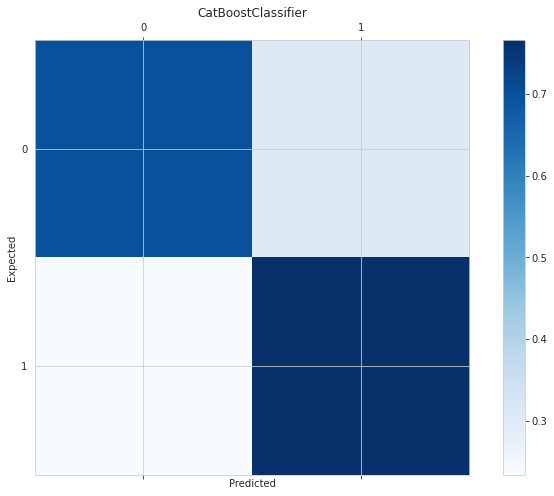

In [531]:
cat_ext_kda_actions = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
models = [("CAT", cat_ext_kda_actions)]

for model in models:
    model[1].fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

In [532]:
df_test_extended_group = team_transformation_extended(df_test_features_extended, total=True, mean=False, std=False, max_=False, min_=False)
# df_test_win_rate = replace_win_rate(df_test_features_group, hero_win_rate)
df_test_replaced = replace_features(df_test_extended_group)
df_test_dropped = drop_unnecessary_cols(df_test_replaced, unnecessary_columns)
df_test_extended_win_rate = replace_win_rate(df_test_dropped, hero_win_rate)
df_test_extended_win_rate

,game_time,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,...,d_total_obs_placed,d_total_sen_placed,d_total_num_purch,d_total_damage,d_total_damage_taken,d_total_item_uses,d_total_ability_uses,d_total_num_ab_upg,r_KDA,d_KDA
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,11,0.478771,0.532544,0.500860,0.496883,0.479520,0.506472,0.484248,0.479012,...,1,0,35.0,9445.0,1555.0,12.0,11.0,0.0,0.000000,inf
46a0ddce8f7ed2a8d9bd5edcbb925682,576,4,0.500860,0.533477,0.526891,0.485652,0.499213,0.500278,0.447040,0.529527,...,3,0,73.0,69031.0,22808.0,65.0,82.0,16.0,7.000000,0.285714
b1b35ff97723d9b7ade1c9c3cf48f770,453,3,0.542066,0.518677,0.525140,0.484259,0.453865,0.484151,0.564495,0.504509,...,0,0,40.0,54223.0,9404.0,35.0,70.0,11.0,1.250000,3.000000
ab3cc6ccac661a1385e73a2e9f21313a,721,1,0.506521,0.480401,0.482728,0.460628,0.484259,0.459693,0.552239,0.469424,...,4,1,93.0,72194.0,22461.0,97.0,101.0,27.0,1.500000,2.333333
54aaab1cb8cc5df3c253641618673266,752,0,0.529527,0.522663,0.578174,0.500860,0.484259,0.465587,0.511780,0.552239,...,3,2,81.0,99694.0,21226.0,67.0,162.0,26.0,4.000000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,0,0.462279,0.501471,0.500278,0.457213,0.484259,0.564495,0.499167,0.524857,...,2,0,47.0,63427.0,14730.0,68.0,56.0,19.0,7.000000,0.250000
06e2b42495855647830ccc6d466f913c,2561,7,0.522663,0.484259,0.491215,0.482767,0.533477,0.496032,0.525140,0.504396,...,18,6,219.0,524181.0,135446.0,331.0,534.0,87.0,1.791667,2.333333
defd0caeed6ea83d7d5fbdec013fe7d1,1783,23,0.510467,0.526944,0.478078,0.497983,0.499029,0.500860,0.504396,0.578174,...,11,6,146.0,299117.0,79933.0,213.0,375.0,67.0,1.593750,4.142857


In [533]:
X_test = df_test_extended_win_rate.values

y_test_pred = cat_ext_kda_actions.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [534]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_22-27-45.csv


Score: 0.82959

In [535]:
unnecessary_columns = ['game_mode', 'lobby_type', 'objectives_len']

df_dropped = drop_unnecessary_cols(df_extended_group, unnecessary_columns)

df_dropped.columns

Index(['game_time', 'chat_len', 'r1_hero_id', 'r2_hero_id', 'r3_hero_id',
       'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id',
       'd4_hero_id', 'd5_hero_id', 'r_total_kills', 'r_total_deaths',
       'r_total_assists', 'r_total_denies', 'r_total_gold', 'r_total_lh',
       'r_total_xp', 'r_total_health', 'r_total_max_health',
       'r_total_max_mana', 'r_total_level', 'r_total_x', 'r_total_y',
       'r_total_stuns', 'r_total_creeps_stacked', 'r_total_camps_stacked',
       'r_total_rune_pickups', 'r_total_firstblood_claimed',
       'r_total_teamfight_participation', 'r_total_towers_killed',
       'r_total_roshans_killed', 'r_total_obs_placed', 'r_total_sen_placed',
       'r_total_num_purch', 'r_total_damage', 'r_total_damage_taken',
       'r_total_item_uses', 'r_total_ability_uses', 'r_total_actions',
       'r_total_num_ab_upg', 'd_total_kills', 'd_total_deaths',
       'd_total_assists', 'd_total_denies', 'd_total_gold', 'd_total_lh',
       'd_total

In [536]:
X_train, X_valid, y_train, y_valid = train_test_split(df_dropped, df_train_targets["radiant_win"], 
                                                      test_size=0.3, 
                                                      random_state=SEED)


In [537]:
hero_win_rate = calc_win_rate(X_train, y_train)
df_X_train_win_rate = replace_win_rate(X_train, hero_win_rate)
df_X_valid_win_rate = replace_win_rate(X_valid, hero_win_rate)

In [538]:
X_train = df_X_train_win_rate.values
X_valid = df_X_valid_win_rate.values
y_train = y_train.values.astype("int8")
y_valid = y_valid.values.astype("int8")

CatBoostClassifier: 0.8081
accuracy_score:	0.7376
precision_score:0.7374
recall_score: 	0.7356
f1_score: 	0.7361


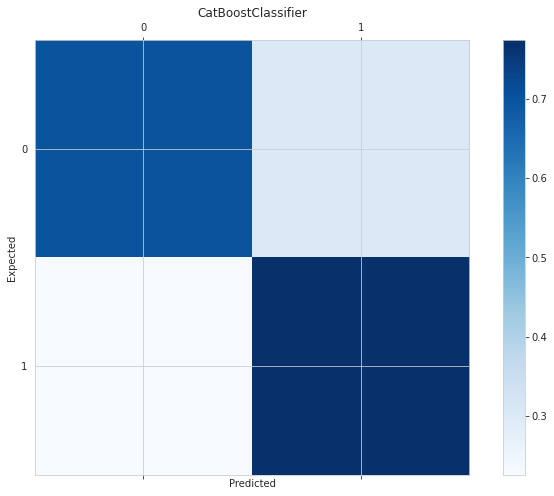

In [539]:
cat_ext_kda_actions = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
models = [("CAT", cat_ext_kda_actions)]

for model in models:
    model[1].fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

In [540]:
df_test_extended_group = team_transformation_extended(df_test_features_extended, total=True, mean=False, std=False, max_=False, min_=False)
# df_test_win_rate = replace_win_rate(df_test_features_group, hero_win_rate)
df_test_dropped = drop_unnecessary_cols(df_test_extended_group, unnecessary_columns)
df_test_extended_win_rate = replace_win_rate(df_test_dropped, hero_win_rate)
df_test_extended_win_rate

,game_time,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,...,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed,d_total_num_purch,d_total_damage,d_total_damage_taken,d_total_item_uses,d_total_ability_uses,d_total_actions,d_total_num_ab_upg
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,11,0.478771,0.532544,0.500860,0.496883,0.479520,0.506472,0.484248,0.479012,...,0,1,0,35.0,9445.0,1555.0,12.0,11.0,2756.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,4,0.500860,0.533477,0.526891,0.485652,0.499213,0.500278,0.447040,0.529527,...,0,3,0,73.0,69031.0,22808.0,65.0,82.0,11299.0,16.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,3,0.542066,0.518677,0.525140,0.484259,0.453865,0.484151,0.564495,0.504509,...,0,0,0,40.0,54223.0,9404.0,35.0,70.0,4581.0,11.0
ab3cc6ccac661a1385e73a2e9f21313a,721,1,0.506521,0.480401,0.482728,0.460628,0.484259,0.459693,0.552239,0.469424,...,0,4,1,93.0,72194.0,22461.0,97.0,101.0,12498.0,27.0
54aaab1cb8cc5df3c253641618673266,752,0,0.529527,0.522663,0.578174,0.500860,0.484259,0.465587,0.511780,0.552239,...,0,3,2,81.0,99694.0,21226.0,67.0,162.0,10277.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,0,0.462279,0.501471,0.500278,0.457213,0.484259,0.564495,0.499167,0.524857,...,0,2,0,47.0,63427.0,14730.0,68.0,56.0,8572.0,19.0
06e2b42495855647830ccc6d466f913c,2561,7,0.522663,0.484259,0.491215,0.482767,0.533477,0.496032,0.525140,0.504396,...,2,18,6,219.0,524181.0,135446.0,331.0,534.0,17528.0,87.0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,23,0.510467,0.526944,0.478078,0.497983,0.499029,0.500860,0.504396,0.578174,...,0,11,6,146.0,299117.0,79933.0,213.0,375.0,26536.0,67.0


In [541]:
X_test = df_test_extended_win_rate.values

y_test_pred = cat_ext_kda_actions.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [542]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_22-31-49.csv


Score: 0.83503

Best Parameters

In [543]:
# Log loss
learning_rate = [ 0.01, 0.05, 0.1, 0.3 ]
depth = [2, 5, 8, 10]
param_grid = {
    'learning_rate': learning_rate,
    'depth': depth,
    'l2_leaf_reg': [1]
    
}

cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
grid_search_result = cat.grid_search(param_grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5554593132
bestIteration = 999

0:	loss: 0.5554593	best: 0.5554593 (0)	total: 5.72s	remaining: 1m 25s

bestTest = 0.5187763732
bestIteration = 998

1:	loss: 0.5187764	best: 0.5187764 (1)	total: 15.6s	remaining: 1m 49s

bestTest = 0.5102384371
bestIteration = 996

2:	loss: 0.5102384	best: 0.5102384 (2)	total: 23.5s	remaining: 1m 41s

bestTest = 0.5123604972
bestIteration = 450

3:	loss: 0.5123605	best: 0.5102384 (2)	total: 31.3s	remaining: 1m 34s

bestTest = 0.5297019726
bestIteration = 999

4:	loss: 0.5297020	best: 0.5102384 (2)	total: 47.3s	remaining: 1m 44s

bestTest = 0.5085725205
bestIteration = 746

5:	loss: 0.5085725	best: 0.5085725 (5)	total: 1m 1s	remaining: 1m 43s

bestTest = 0.5114641797
bestIteration = 525

6:	loss: 0.5114642	best: 0.5085725 (5)	total: 1m 17s	remaining: 1m 39s

bestTest = 0.5209720591
bestIteration = 88

7:	loss: 0.5209721	best: 0.5085725 (5)	total: 1m 32s	remaining: 1m 32s

bestTest = 0.5222927653
bestIteration = 999

8:	loss: 0.5222928	best: 

In [544]:
print(grid_search_result['params']) # Chosen as the lowest log

{'depth': 5, 'l2_leaf_reg': 1, 'learning_rate': 0.05}


Optimising the last model:

CatBoostClassifier: 0.8073
accuracy_score:	0.7341
precision_score:0.7338
recall_score: 	0.7321
f1_score: 	0.7325


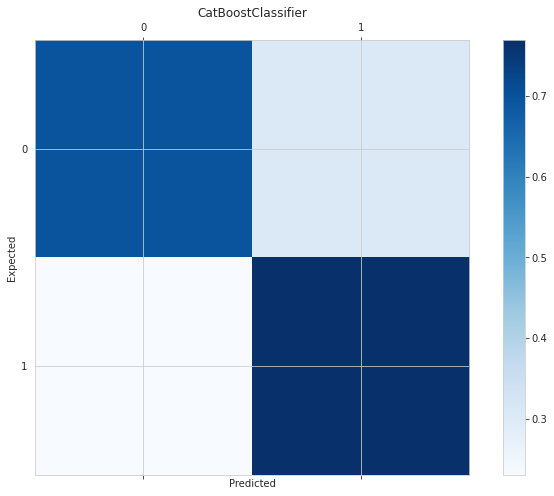

In [545]:
cat_ext_kda_actions = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, depth=5, l2_leaf_reg=1, learning_rate=0.05)
models = [("CAT", cat_ext_kda_actions)]

for model in models:
    model[1].fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

In [546]:
df_test_extended_group = team_transformation_extended(df_test_features_extended, total=True, mean=False, std=False, max_=False, min_=False)
# df_test_win_rate = replace_win_rate(df_test_features_group, hero_win_rate)
df_test_dropped = drop_unnecessary_cols(df_test_extended_group, unnecessary_columns)
df_test_extended_win_rate = replace_win_rate(df_test_dropped, hero_win_rate)
df_test_extended_win_rate

,game_time,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,...,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed,d_total_num_purch,d_total_damage,d_total_damage_taken,d_total_item_uses,d_total_ability_uses,d_total_actions,d_total_num_ab_upg
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,11,0.478771,0.532544,0.500860,0.496883,0.479520,0.506472,0.484248,0.479012,...,0,1,0,35.0,9445.0,1555.0,12.0,11.0,2756.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,4,0.500860,0.533477,0.526891,0.485652,0.499213,0.500278,0.447040,0.529527,...,0,3,0,73.0,69031.0,22808.0,65.0,82.0,11299.0,16.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,3,0.542066,0.518677,0.525140,0.484259,0.453865,0.484151,0.564495,0.504509,...,0,0,0,40.0,54223.0,9404.0,35.0,70.0,4581.0,11.0
ab3cc6ccac661a1385e73a2e9f21313a,721,1,0.506521,0.480401,0.482728,0.460628,0.484259,0.459693,0.552239,0.469424,...,0,4,1,93.0,72194.0,22461.0,97.0,101.0,12498.0,27.0
54aaab1cb8cc5df3c253641618673266,752,0,0.529527,0.522663,0.578174,0.500860,0.484259,0.465587,0.511780,0.552239,...,0,3,2,81.0,99694.0,21226.0,67.0,162.0,10277.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,0,0.462279,0.501471,0.500278,0.457213,0.484259,0.564495,0.499167,0.524857,...,0,2,0,47.0,63427.0,14730.0,68.0,56.0,8572.0,19.0
06e2b42495855647830ccc6d466f913c,2561,7,0.522663,0.484259,0.491215,0.482767,0.533477,0.496032,0.525140,0.504396,...,2,18,6,219.0,524181.0,135446.0,331.0,534.0,17528.0,87.0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,23,0.510467,0.526944,0.478078,0.497983,0.499029,0.500860,0.504396,0.578174,...,0,11,6,146.0,299117.0,79933.0,213.0,375.0,26536.0,67.0


In [547]:
X_test = df_test_extended_win_rate.values

y_test_pred = cat_ext_kda_actions.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [548]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_22-48-46.csv


Optimizing the best model:

In [549]:
df_train_features_team_group.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
       'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id',
       'r_total_kills', 'r_total_deaths', 'r_total_assists', 'r_total_denies',
       'r_total_gold', 'r_total_lh', 'r_total_xp', 'r_total_health',
       'r_total_max_health', 'r_total_max_mana', 'r_total_level', 'r_total_x',
       'r_total_y', 'r_total_stuns', 'r_total_creeps_stacked',
       'r_total_camps_stacked', 'r_total_rune_pickups',
       'r_total_firstblood_claimed', 'r_total_teamfight_participation',
       'r_total_towers_killed', 'r_total_roshans_killed', 'r_total_obs_placed',
       'r_total_sen_placed', 'd_total_kills', 'd_total_deaths',
       'd_total_assists', 'd_total_denies', 'd_total_gold', 'd_total_lh',
       'd_total_xp', 'd_total_health', 'd_total_max_health',
       'd_total_max_mana', 'd_total_level', 'd_total_x', 'd_total_y',
  

In [550]:
X = df_train_features_team_group.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [551]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train_features_team_group, df_train_targets["radiant_win"], 
                                                      test_size=0.3, 
                                                      random_state=SEED)


In [552]:
hero_win_rate = calc_win_rate(X_train, y_train)
df_X_train_win_rate = replace_win_rate(X_train, hero_win_rate)
df_X_valid_win_rate = replace_win_rate(X_valid, hero_win_rate)

In [553]:
X_train = df_X_train_win_rate.values
X_valid = df_X_valid_win_rate.values
y_train = y_train.values.astype("int8")
y_valid = y_valid.values.astype("int8")

CatBoostClassifier: 0.8074
accuracy_score:	0.7383
precision_score:0.7381
recall_score: 	0.7363
f1_score: 	0.7367


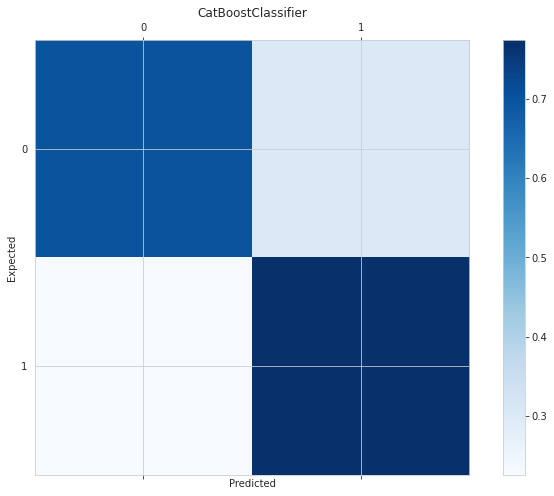

In [554]:
cat_opt = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, depth=5, l2_leaf_reg=1, learning_rate=0.05)
models = [("CAT", cat_opt)]

for model in models:
    model[1].fit(X_train, y_train)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
    cv_scores = cross_val_score(model[1], X, y, cv=cv, scoring="roc_auc")
    print(f"{model[1].__class__.__name__}: {round(cv_scores.mean(), 4)}")
    
    y_pred = model[1].predict(X_valid)
    print(f'accuracy_score:\t{round(accuracy_score(y_valid, y_pred), 4)}')
    print(f'precision_score:{round(precision_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'recall_score: \t{round(recall_score(y_valid, y_pred, average="macro"), 4)}')
    print(f'f1_score: \t{round(f1_score(y_valid, y_pred, average="macro"), 4)}')
    

    conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred, normalize='true')
    # print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title(model[1].__class__.__name__)
    plt.show()

In [555]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")
df_test_features_group = team_transformation(df_test_features, total=True, mean=False, std=False, max_=False, min_=False)
df_test_win_rate = replace_win_rate(df_test_features_group, hero_win_rate)
df_test_win_rate

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,d_total_stuns,d_total_creeps_stacked,d_total_camps_stacked,d_total_rune_pickups,d_total_firstblood_claimed,d_total_teamfight_participation,d_total_towers_killed,d_total_roshans_killed,d_total_obs_placed,d_total_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0.478771,0.532544,0.500860,0.496883,0.479520,...,0.299948,0,0,7,1,2.00000,0,0,1,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,0.500860,0.533477,0.526891,0.485652,0.499213,...,13.663390,6,2,11,0,1.00000,0,0,3,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0.542066,0.518677,0.525140,0.484259,0.453865,...,26.826797,2,1,8,0,1.50000,0,0,0,0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,0.506521,0.480401,0.482728,0.460628,0.484259,...,4.632218,0,0,15,1,2.50000,0,0,4,1
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,0.529527,0.522663,0.578174,0.500860,0.484259,...,12.830091,9,2,16,0,2.00000,0,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,0.462279,0.501471,0.500278,0.457213,0.484259,...,5.598577,3,2,3,0,1.00000,0,0,2,0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,0.522663,0.484259,0.491215,0.482767,0.533477,...,300.799313,0,0,62,1,2.18750,4,2,18,6
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,0.510467,0.526944,0.478078,0.497983,0.499029,...,70.816496,6,2,34,0,2.71875,3,0,11,6


In [556]:
X_test = df_test_win_rate.values

y_test_pred = cat_ext.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [557]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_22-50-46.csv


Score: 0.83537